env: VideoMusic

# 0.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import sys
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter, defaultdict

sys.path.append('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_keyframe_detector')
sys.path.append("/storage/arkady/Glinka/music-transformer/video_conditioning/content/computervision-recipes")  # import utils_cv ...

os.environ['LD_PRELOAD'] = '/usr/lib/x86_64-linux-gnu/libffi.so.7'

selected_videos = [25, 5, 14, 17, 27]
ind = 2
path_mp4 = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
    / 'content' / 'video_data' / f'video_ad{selected_videos[ind]}.mp4'
assert os.path.exists(path_mp4)

!pwd
%rm -rf /home/arkady/.cache/torch/hub/moabitcoin_ig65m-pytorch_master

/storage/arkady/Glinka/music-transformer/video_conditioning


# 1. mp4 -> midi

In [13]:
from video_utils.mp4_to_midi import mp4_to_midi

path_midi = mp4_to_midi(
    path_to_mp4=path_mp4,
    tempdir='./tmp_e2e',
)
print(path_midi)

MoviePy - Writing audio in /storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/video_ad27.mp3


MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/video_ad27.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 1/1 [00:05<00:00,  6.00s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/video_ad27_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/video_ad27_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/video_ad27_Instruments.wav...


  Creating midi...
  💅 Saved to /storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/video_ad27_Instruments_basic_pitch.mid

✨ Done ✨

/storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/video_ad27/video_ad27.mid


# 2. kvm generation

## 2.1 kvm1 TODO

In [4]:
path_mp4

PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad17.mp4')

In [4]:
from collections import deque, defaultdict
import cv2
import sys

# sys.path.append("/storage/arkady/Glinka/music_generation/content/computervision-recipes")
from utils_cv.action_recognition.data import KINETICS, Urls
from utils_cv.action_recognition.dataset import get_transforms
from utils_cv.action_recognition.model import VideoLearner
from utils_cv.action_recognition.references import transforms_video as transforms
from utils_cv.common.gpu import system_info, torch_device
from utils_cv.common.data import data_path
import decord #
from ipywidgets import HBox, HTML, Layout, VBox, Widget, Label

LABELS = KINETICS.class_names
NUM_FRAMES = 8  # 8 or 32.
IM_SCALE = 128  # resize then crop
INPUT_SIZE = 112  # input clip size: 3 x NUM_FRAMES x 112 x 112
SCORE_thresHOLD = 0.16
AVERAGING_SIZE = 1

learner = VideoLearner(
        base_model="kinetics",
        sample_length=NUM_FRAMES,
)

transforms = get_transforms(train=False)
# d_caption = IPython.display.display("Preparing...", display_id=2)
l = len(LABELS)
# def update_println(println):
#   d_caption.update(IPython.display.HTML(println))
# key_video_moments = defaultdict(list)

def VideoToMoments(path_video, SCORE_thresHOLD=0.16) -> list[int]:
    cap = cv2.VideoCapture(path_video)
    FPS = int(cap.get(cv2.CAP_PROP_FPS))

    print('Video: ', path_video, 'with fps:', FPS)
    video_reader = decord.VideoReader(path_video)
    window = deque()
    scores_cache = deque()
    scores_sum = np.zeros(len(LABELS))
    w_text = HTML(layout=Layout(padding="0 0 0 100px"))

    cur_frame = 0
    prev_frame = 0
    prev_sets = []
    num = 1
    prev_name = ''
    prev_set = set()
    video_name = path_video.split('/')[-1]
    key_video_moments = []
    while True:
        print('.', end='')
        try:
            frame = video_reader.next().asnumpy()
            window.append(frame)
            def update_println(println):
                    w_text.value = println

            if len(window) == NUM_FRAMES:
                    a, set_a = learner.predict_frames(
                            window,
                            scores_cache,
                            scores_sum,
                            None,
                            30,
                            SCORE_thresHOLD,
                            LABELS,
                            LABELS,
                            get_transforms(train=False),
                            update_println,
                    )

                #   print(a, set_a)
                    cur_frame_sec = cur_frame//FPS + (cur_frame%FPS)/100
                    if len(prev_sets) > FPS:
                        prev_cumm_set = set().union(*prev_sets[-FPS:])
                    else:
                        prev_cumm_set = set().union(*prev_sets)
                    if cur_frame == 0 or (a and a not in prev_cumm_set and cur_frame_sec - prev_frame > 0.5):
                        key_video_moments.append(float("{:.2f}".format(cur_frame_sec)))
                        # print(num, ': Секунда: ', "{:.2f}".format(cur_frame_sec), ', началось действие: ', a)
                        num += 1
                        prev_frame = cur_frame_sec
                        prev_name = a
                        prev_set = set_a
                        prev_sets.append(prev_set)
            else:
                    w_text.value = "Preparing..."
            cur_frame += 1
        except:
            break

    return key_video_moments

Loading r2plus1d_34_8_kinetics model


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/moabitcoin/ig65m-pytorch/zipball/master" to /home/arkady/.cache/torch/hub/master.zip


In [ ]:
kvm1 = VideoToMoments(str(path_mp4), SCORE_thresHOLD=0.01)
kvm1

In [35]:
with open("./kvm1.json") as f:
    kvm1 = json.load(f)
kvm1[path_mp4.name]

[1.11, 10.23, 12.07, 13.13, 20.09, 47.2]

## kvm1 improve TODO

In [13]:
import torch
torch.cuda.is_available()

True

In [ ]:
import cv2
import numpy as np
import decord
import torch
from collections import deque
from utils_cv.action_recognition.data import KINETICS
from utils_cv.action_recognition.dataset import get_transforms
from utils_cv.action_recognition.model import VideoLearner

LABELS = KINETICS.class_names
NUM_FRAMES = 8
SCORE_THRESHOLD = 0.16

learner = VideoLearner(
    base_model="kinetics",
    sample_length=NUM_FRAMES,
)

transforms = get_transforms(train=False)

def VideoToMoments(path_video, SCORE_THRESHOLD=0.16) -> list:
    path_video = str(path_video)
    cap = cv2.VideoCapture(path_video)
    FPS = int(cap.get(cv2.CAP_PROP_FPS))
    print(f'Video: {path_video}, FPS: {FPS}')

    video_reader = decord.VideoReader(path_video)
    window = deque(maxlen=NUM_FRAMES)
    scores_cache = deque()
    scores_sum = np.zeros(len(LABELS))
    
    key_video_moments = []
    prev_frame_sec = 0
    prev_sets = []

    for cur_frame, frame in enumerate(video_reader):
        frame = frame.asnumpy()
        window.append(frame)

        if len(window) == NUM_FRAMES:
            # Check if CUDA is available
            if torch.cuda.is_available():
                device = torch.device('cuda')
            else:
                device = torch.device('cpu')

            learner.model.to(device)
            learner.model.eval()

            action, set_a = learner.predict_frames(
                window,
                scores_cache,
                scores_sum,
                None,
                30,
                SCORE_THRESHOLD,
                LABELS,
                LABELS,
                transforms,
                None,
            )

            cur_frame_sec = cur_frame // FPS + (cur_frame % FPS) / FPS
            if len(prev_sets) > FPS:
                prev_cumm_set = set().union(*prev_sets[-FPS:])
            else:
                prev_cumm_set = set().union(*prev_sets)

            if action and (cur_frame == 0 or (action not in prev_cumm_set and cur_frame_sec - prev_frame_sec > 0.5)):
                key_video_moments.append(float(f"{cur_frame_sec:.2f}"))
                prev_frame_sec = cur_frame_sec
                prev_sets.append(set_a)

    return key_video_moments


key_moments = VideoToMoments(path_mp4)

Loading r2plus1d_34_8_kinetics model


Downloading: "https://github.com/moabitcoin/ig65m-pytorch/zipball/master" to /home/arkady/.cache/torch/hub/master.zip


## 2.2 kvm2

In [15]:
!{sys.executable} content/video_keyframe_detector/cli.py -s {str(path_mp4)} -d tmp_e2e -t 0.9

Path(dest) / Path(source).stem=PosixPath('tmp_e2e/video_ad27')
Figure(1200x600)
keyframe 2 happened at 1.0 sec.
keyframe 3 happened at 1.1 sec.


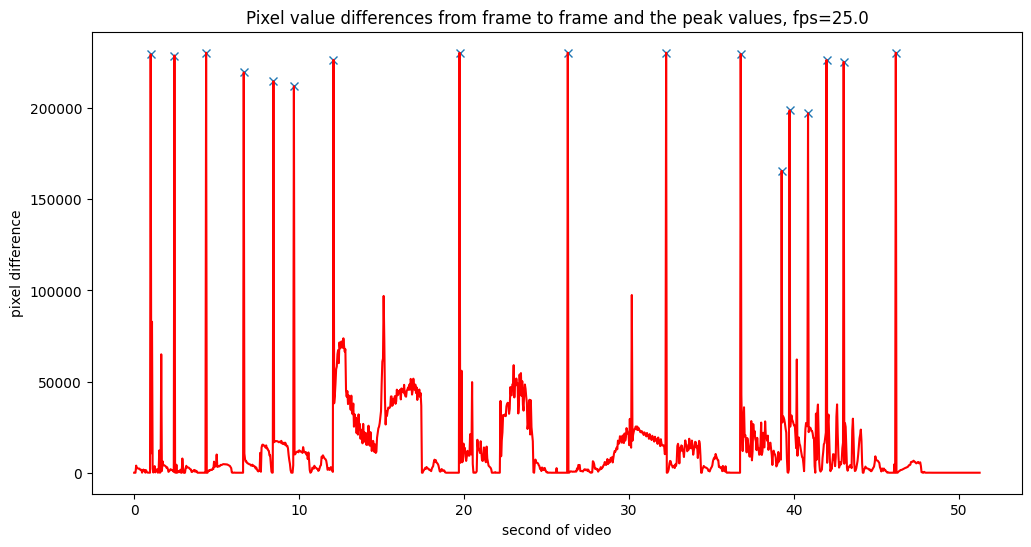

In [127]:
from KeyFrameDetector.key_frame_detector import keyframeDetection

kvm2 = keyframeDetection(source=str(path_mp4), dest='tmp_e2e', thres=0.6,
                  verbose=False,
                  plotMetrics=True
                  )

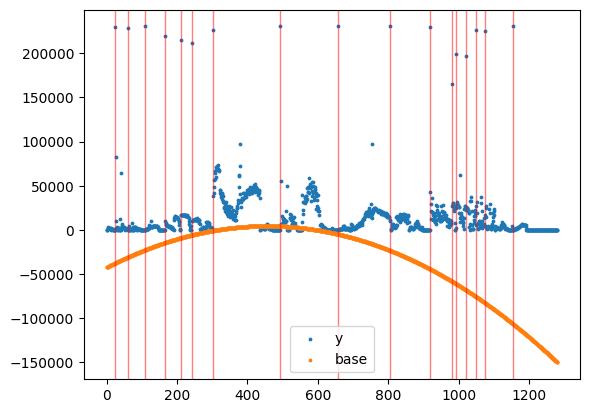

In [118]:
import peakutils
thres = 0.5

lstdiffMag = kvm2[0]
y = np.array(lstdiffMag)
base = peakutils.baseline(y, 2)
indices = peakutils.indexes(y-base, thres, min_dist=1)

x = np.arange(len(lstdiffMag))
# plt.scatter(x, lstdiffMag, label='lstdiffMag')
plt.scatter(x, y, label='y', s=3)
plt.scatter(x, base * 400, label='base', s=3)
# plt.scatter(x, indices, label='indices')
plt.legend()
for ind in indices:
    plt.axvline(ind, ymax=300000, ymin=-150000, c='r', lw=1, alpha=1/2)

In [95]:
indices

array([  25,   61,  109,  166,  211,  242,  302,  493,  657,  806,  919,
        981,  993, 1021, 1049, 1075, 1154])

In [2]:
from video_utils.kvm import extract_kvm2

kvm2, fps2 = extract_kvm2(path_mp4, thres=0.6)

np.array(kvm2) / fps2

100%|██████████| 1282/1282 [00:02<00:00, 575.44it/s]


array([ 1.  ,  2.44,  4.36,  6.64,  8.44,  9.68, 12.08, 19.72, 26.28,
       32.24, 36.76, 39.24, 39.72, 40.84, 41.96, 43.  , 46.16])

## 2.3 kvm3 (gpt-4o)

In [31]:
from video_utils.kvm import extract_kvm3

kvm3 = extract_kvm3(path_mp4)
kvm3[0][:5]

VideoManager is deprecated and will be removed.


[44, 129, 203, 337, 534]

In [46]:
kvm3[2]

[(00:00:00.000 [frame=0, fps=25.000], 00:00:03.560 [frame=89, fps=25.000]),
 (00:00:03.560 [frame=89, fps=25.000], 00:00:06.760 [frame=169, fps=25.000]),
 (00:00:06.760 [frame=169, fps=25.000], 00:00:09.480 [frame=237, fps=25.000]),
 (00:00:09.480 [frame=237, fps=25.000], 00:00:17.480 [frame=437, fps=25.000]),
 (00:00:17.480 [frame=437, fps=25.000], 00:00:25.240 [frame=631, fps=25.000]),
 (00:00:25.240 [frame=631, fps=25.000], 00:00:28.800 [frame=720, fps=25.000]),
 (00:00:28.800 [frame=720, fps=25.000], 00:00:32.240 [frame=806, fps=25.000]),
 (00:00:32.240 [frame=806, fps=25.000], 00:00:33.080 [frame=827, fps=25.000]),
 (00:00:33.080 [frame=827, fps=25.000], 00:00:33.680 [frame=842, fps=25.000]),
 (00:00:33.680 [frame=842, fps=25.000], 00:00:34.280 [frame=857, fps=25.000]),
 (00:00:34.280 [frame=857, fps=25.000], 00:00:34.880 [frame=872, fps=25.000]),
 (00:00:34.880 [frame=872, fps=25.000], 00:00:36.240 [frame=906, fps=25.000]),
 (00:00:36.240 [frame=906, fps=25.000], 00:00:36.880 [fr

In [50]:
kvm4 = [k[0].get_seconds() for k in kvm3[2]] + [kvm3[2][-1][1].get_seconds()]
kvm4

[0.0,
 3.56,
 6.76,
 9.48,
 17.48,
 25.24,
 28.8,
 32.24,
 33.08,
 33.68,
 34.28,
 34.88,
 36.24,
 36.88,
 39.88,
 40.96,
 42.72,
 45.12,
 46.48,
 51.48,
 57.96]

## kvm5 papers

In [1]:
# не дошли руки, см kvm_research.ipynb

## kvms compared

path_mp4=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4')


 37%|███▋      | 477/1282 [00:00<00:01, 760.66it/s]

100%|██████████| 1282/1282 [00:01<00:00, 736.72it/s]
VideoManager is deprecated and will be removed.


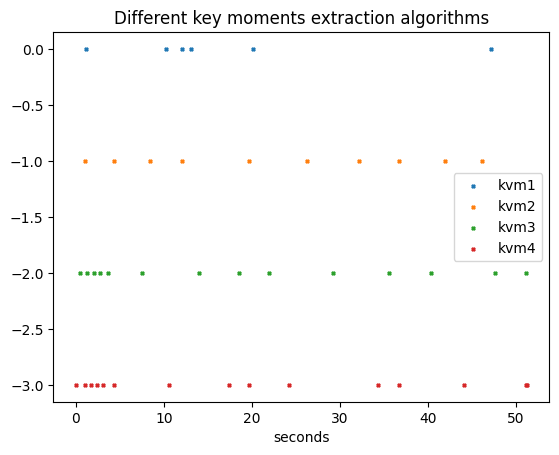

In [3]:
import matplotlib.pyplot as plt
from video_utils.kvm import extract_kvm3, extract_kvm2
import numpy as np

ind = 14
path_mp4 = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
    / 'content' / 'video_data' / f'video_ad{ind}.mp4'

print(f'{path_mp4=}')


with open("./kvm1.json") as f:
    kvm1 = json.load(f)
kvm1 = kvm1[f'{path_mp4.stem}.mp4']

kvm2, fps2 = extract_kvm2(source=path_mp4, thres=0.6, min_dist=80)
kvm2 = np.array(kvm2) / fps2

kvm3, fps3, *kvm4 = extract_kvm3(path_mp4, threshold=80.0)
kvm3 = np.array(kvm3) / fps3

kvm4 = kvm4[0]
kvm4 = [k[0].get_seconds() for k in kvm4] + [kvm4[-1][1].get_seconds()]

kvms = {
    'kvm1': kvm1,
    'kvm2': kvm2,
    'kvm3': kvm3,
    'kvm4': kvm4
}

# plt.figure(figsize=(6, 3))
for i, (name, x) in enumerate(kvms.items()):
    plt.scatter(x, -np.ones_like(x) * i, label=name, s=5, marker='X')
plt.legend(loc='right')
plt.xlabel('seconds')
plt.title('Different key moments extraction algorithms')
plt.show()

In [143]:
# args = extract_kvm3(path_mp4, threshold=70.0)
args[2][5][0].get_frames()

109

## add_time_bar

In [16]:
from video_utils.video_preproces import add_time_bar

# Example usage
add_time_bar(path_mp4, path_mp4.stem + '_bar.mp4')

Moviepy - Building video video_ad14_bar.mp4.
MoviePy - Writing audio in video_ad14_barTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video_ad14_bar.mp4



Moviepy - Done !
Moviepy - video ready video_ad14_bar.mp4


## add_time_bar_with_markers

In [16]:
import cv2
import numpy as np
import os
from moviepy.editor import VideoFileClip

from video_utils.video_preproces import add_time_bar_with_markers

kvm3, fps3 = extract_kvm3(path_mp4, threshold=30.0)
kvm3 = np.array(kvm3) / fps3

add_time_bar_with_markers(
    video_path=path_mp4, 
    output_path=path_mp4.stem + '_zxc.mp4', 
    key_moments=kvm3,
    key_moments_2=kvm2,
)

VideoManager is deprecated and will be removed.


Moviepy - Building video video_ad14_zxc.mp4.
MoviePy - Writing audio in video_ad14_zxcTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video_ad14_zxc.mp4



Moviepy - Done !
Moviepy - video ready video_ad14_zxc.mp4


## add_time_bar_with_markers_any

In [75]:
from video_utils.video_preproces import add_time_bar_with_markers_any

# ind = 25
# path_mp4 = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
#     / 'content' / 'video_data' / f'video_ad{ind}.mp4'

add_time_bar_with_markers_any(
    video_path=path_mp4, 
    output_path=path_mp4.stem + '_any.mp4', 
    bar_thickness=6, 
    bar_opacity=0.5, 
    marker_size=5, 
    args=[kvm1,    kvm2,    kvm3,    kvm4][::-1]
)

Moviepy - Building video video_ad25_any.mp4.
MoviePy - Writing audio in video_ad25_anyTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video_ad25_any.mp4



Moviepy - Done !
Moviepy - video ready video_ad25_any.mp4


## перебор threshold

In [95]:
import json
import os
from pathlib import Path


def search_thresholds_for_kvm3(
        path_mp4, 
        min_length=4, 
        max_length=12, 
        max_searches=200
    ):
    """
    Searches for threshold values that result in kvm3 and kvm4 lists of a desired length
    and saves the results to a JSON config file.

    Arguments:
        path_mp4 (str or Path): Path to the input video file.
        min_length (int): Minimum acceptable length of kvm3. Default is 4.
        max_length (int): Maximum acceptable length of kvm3. Default is 12.
        max_searches (int): Maximum number of binary search steps. Default is 200.

    Returns:
        None
    """
    path_mp4 = Path(path_mp4)
    if not os.path.exists(path_mp4):
        return

    config_file = 'kvm_treshold.json'
    
    # Initialize config dictionary
    if os.path.exists(config_file):
        with open(config_file, 'r') as f:
            config = json.load(f)
    else:
        config = {}
        json.dump({}, open(config_file, 'w'))
    
    if path_mp4.stem not in config:
        config[path_mp4.stem] = []

    found_thresholds = set(threshold for threshold, _, __ in config[path_mp4.stem])

    total_iter = -1
    low, high = 1, max_searches
    while low <= high and len(found_thresholds) < 3:
        total_iter += 1
        if total_iter > max_searches:
            break
        mid = (low + high) // 2
        kvm3, fps3, kvm4 = extract_kvm3(path_mp4, threshold=mid)
        # print(f'{kvm4=}')
        kvm4 = [] if (not kvm4) else [k[0].get_seconds() for k in kvm4] + [kvm4[-1][1].get_seconds()]
        len_kvm3 = len(kvm3)
        print(f'{mid=}, {len_kvm3=}')

        if min_length <= len_kvm3 <= max_length and mid not in found_thresholds:
            print(f'writing {mid}')
            found_thresholds.add(mid)
            # config[path_mp4.stem].append([mid, len_kvm3, kvm4])
            config[path_mp4.stem].append(
                {
                    'threshold': mid,
                    'len': len_kvm3,
                    'kvm4': kvm4,
                }
                )
            with open(config_file, 'w') as f:
                json.dump(config, f, indent=4)
        
        if len_kvm3 < min_length:
            high = mid - 1
        elif len_kvm3 > max_length:
            low = mid + 1
        else:
            # If we found a valid threshold, continue searching around it
            # low, high = mid - 1, mid + 1
            if len_kvm3 > (min_length + max_length) / 2:
                low = mid + 1
            else:
                high = mid - 1

ind = 14
path_mp4 = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
    / 'content' / 'video_data' / f'video_ad{ind}.mp4'
print(path_mp4)

search_thresholds_for_kvm3(
    path_mp4=path_mp4,
    min_length=5, 
    max_length=12, 
    max_searches=200
)

VideoManager is deprecated and will be removed.


/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=8
writing 100


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=25


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=18


VideoManager is deprecated and will be removed.


mid=87, len_kvm3=12
writing 87
mid=93, len_kvm3=8
writing 93


In [96]:
for ind in range(0, 85):
    path_mp4 = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
        / 'content' / 'video_data' / f'video_ad{ind}.mp4'
    print(path_mp4)

    search_thresholds_for_kvm3(
        path_mp4=path_mp4,
        min_length=5, 
        max_length=12, 
        max_searches=200
    )

VideoManager is deprecated and will be removed.


/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad0.mp4
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad1.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=5
writing 100


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=42


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=12
writing 75


VideoManager is deprecated and will be removed.


mid=87, len_kvm3=7
writing 87
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad2.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=6
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=12
writing 37


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=8
writing 43
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad3.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=11
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=6
writing 56


VideoManager is deprecated and will be removed.


mid=53, len_kvm3=8
writing 53
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad4.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=18, len_kvm3=9
writing 18


VideoManager is deprecated and will be removed.


mid=21, len_kvm3=5
writing 21


VideoManager is deprecated and will be removed.


mid=19, len_kvm3=6
writing 19
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad5.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=7
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=11
writing 43


VideoManager is deprecated and will be removed.


mid=46, len_kvm3=11
writing 46
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad6.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=7
writing 12


VideoManager is deprecated and will be removed.


mid=6, len_kvm3=9
writing 6


VideoManager is deprecated and will be removed.


mid=9, len_kvm3=7
writing 9
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad7.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=31


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=12
writing 75


VideoManager is deprecated and will be removed.


mid=87, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=81, len_kvm3=10
writing 81


VideoManager is deprecated and will be removed.


mid=84, len_kvm3=7
writing 84
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad8.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=37


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=26


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=46, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=44, len_kvm3=10
writing 44


VideoManager is deprecated and will be removed.


mid=45, len_kvm3=9
writing 45
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad9.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=26


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=16


VideoManager is deprecated and will be removed.


mid=87, len_kvm3=10
writing 87


VideoManager is deprecated and will be removed.


mid=93, len_kvm3=5
writing 93


VideoManager is deprecated and will be removed.


mid=90, len_kvm3=7
writing 90
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad10.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=5
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=5
writing 37


VideoManager is deprecated and will be removed.


mid=31, len_kvm3=9
writing 31
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad11.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=10
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=9
writing 56


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=5
writing 59
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad12.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=7
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=10
writing 12


VideoManager is deprecated and will be removed.


mid=18, len_kvm3=8
writing 18
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad13.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=8
writing 37


VideoManager is deprecated and will be removed.


mid=31, len_kvm3=12
writing 31


VideoManager is deprecated and will be removed.


mid=34, len_kvm3=9
writing 34
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=8
writing 100


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=25


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=18


VideoManager is deprecated and will be removed.


mid=87, len_kvm3=12
writing 87
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad15.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=6
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=8
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=15


VideoManager is deprecated and will be removed.


mid=18, len_kvm3=9
writing 18
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad16.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=11
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=5
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=7
writing 56
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad17.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=19


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=6
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=9
writing 56


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=6
writing 59
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad18.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=9
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=53, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=51, len_kvm3=6
writing 51
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad19.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=7
writing 43


VideoManager is deprecated and will be removed.


mid=40, len_kvm3=8
writing 40


VideoManager is deprecated and will be removed.


mid=38, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=39, len_kvm3=10
writing 39
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad20.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=7
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=24


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=23


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=18


VideoManager is deprecated and will be removed.


mid=46, len_kvm3=16


VideoManager is deprecated and will be removed.


mid=48, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=49, len_kvm3=9
writing 49
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad21.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=62


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=7
writing 75


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=38


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=21


VideoManager is deprecated and will be removed.


mid=71, len_kvm3=12
writing 71


VideoManager is deprecated and will be removed.


mid=73, len_kvm3=11
writing 73
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad22.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=15


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=6
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=12
writing 56


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=10
writing 59
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad23.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=10
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=8
writing 37


VideoManager is deprecated and will be removed.


mid=31, len_kvm3=10
writing 31
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad24.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=21


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=9
writing 56


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=5
writing 59


VideoManager is deprecated and will be removed.


mid=57, len_kvm3=6
writing 57
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad25.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=27


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=12
writing 62


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=6
writing 68


VideoManager is deprecated and will be removed.


mid=65, len_kvm3=8
writing 65
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad26.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=5
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=10
writing 43


VideoManager is deprecated and will be removed.


mid=46, len_kvm3=7
writing 46
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad27.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=5
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=7
writing 12


VideoManager is deprecated and will be removed.


mid=6, len_kvm3=8
writing 6
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad28.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=10
writing 12


VideoManager is deprecated and will be removed.


mid=18, len_kvm3=7
writing 18


VideoManager is deprecated and will be removed.


mid=15, len_kvm3=8
writing 15
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad29.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=6
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=10
writing 56


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=9
writing 59
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad30.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=9
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=53, len_kvm3=6
writing 53


VideoManager is deprecated and will be removed.


mid=51, len_kvm3=9
writing 51
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad31.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=8
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=12
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=11
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad32.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=31


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=21


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=9
writing 68


VideoManager is deprecated and will be removed.


mid=71, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=69, len_kvm3=8
writing 69
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad33.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=11
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=10
writing 62


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=8
writing 68
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad34.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=5
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=7
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=12
writing 12
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad35.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=7
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=7
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=7
writing 12
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad36.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=18


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=6
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=10
writing 59


VideoManager is deprecated and will be removed.


mid=60, len_kvm3=8
writing 60
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad37.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=15


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=10
writing 62


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=7
writing 68


VideoManager is deprecated and will be removed.


mid=65, len_kvm3=8
writing 65
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad38.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=7
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=8
writing 56


VideoManager is deprecated and will be removed.


mid=53, len_kvm3=12
writing 53
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad39.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=8
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=8
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=10
writing 12
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad40.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=9
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=6
writing 56


VideoManager is deprecated and will be removed.


mid=53, len_kvm3=9
writing 53
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad41.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=23


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=21


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=71, len_kvm3=8
writing 71


VideoManager is deprecated and will be removed.


mid=69, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=70, len_kvm3=10
writing 70
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad42.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=19


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=5
writing 75


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=10
writing 62


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=9
writing 68
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad43.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=15


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=6
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=10
writing 56


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=7
writing 59
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad44.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=11
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=9
writing 37


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=6
writing 43
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad45.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=22


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=11
writing 68


VideoManager is deprecated and will be removed.


mid=71, len_kvm3=8
writing 71


VideoManager is deprecated and will be removed.


mid=69, len_kvm3=10
writing 69
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad46.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=6
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=18


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=12
writing 37


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=11
writing 43
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad47.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=9
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=5
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=7
writing 56
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad48.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=5
writing 75


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=11
writing 62


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=9
writing 68
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad49.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=21


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=12
writing 62


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=6
writing 68


VideoManager is deprecated and will be removed.


mid=65, len_kvm3=7
writing 65
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad50.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=5
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=8
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=9
writing 12
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad51.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=7
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=12
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=12
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad52.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=6, len_kvm3=5
writing 6


VideoManager is deprecated and will be removed.


mid=3, len_kvm3=7
writing 3


VideoManager is deprecated and will be removed.


mid=1, len_kvm3=7
writing 1
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad53.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=5
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=5
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=5
writing 12
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad54.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=9
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=5
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=7
writing 56
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad55.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=8
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=11
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=10
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad56.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=16


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=8
writing 56


VideoManager is deprecated and will be removed.


mid=53, len_kvm3=12
writing 53


VideoManager is deprecated and will be removed.


mid=54, len_kvm3=10
writing 54
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad57.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=5
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=8
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=18


VideoManager is deprecated and will be removed.


mid=18, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=21, len_kvm3=8
writing 21
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad58.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=5
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=9
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=6
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad59.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=11
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=8
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=8
writing 56
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad60.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=8
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=16


VideoManager is deprecated and will be removed.


mid=18, len_kvm3=8
writing 18


VideoManager is deprecated and will be removed.


mid=15, len_kvm3=11
writing 15
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad61.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=9
writing 62


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=6
writing 68


VideoManager is deprecated and will be removed.


mid=65, len_kvm3=7
writing 65
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad62.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=8
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=10
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=10
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad63.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=17


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=5
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=6
writing 56


VideoManager is deprecated and will be removed.


mid=53, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=54, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=55, len_kvm3=11
writing 55
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad64.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=7
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=8
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=10
writing 12
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad65.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=6
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=9
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=9
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad66.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=8
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=9
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=8
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad67.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=9
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=8
writing 37


VideoManager is deprecated and will be removed.


mid=31, len_kvm3=9
writing 31
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad68.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=8
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=10
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=10
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad69.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=11
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=6
writing 37


VideoManager is deprecated and will be removed.


mid=31, len_kvm3=9
writing 31
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad70.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=6, len_kvm3=11
writing 6


VideoManager is deprecated and will be removed.


mid=9, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=7, len_kvm3=7
writing 7
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad71.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=10
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=5
writing 56


VideoManager is deprecated and will be removed.


mid=53, len_kvm3=9
writing 53
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad72.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=7
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=8
writing 12


VideoManager is deprecated and will be removed.


mid=6, len_kvm3=15


VideoManager is deprecated and will be removed.


mid=9, len_kvm3=11
writing 9
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad73.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=6
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=11
writing 56


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=9
writing 59
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad74.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=9
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=7
writing 37


VideoManager is deprecated and will be removed.


mid=31, len_kvm3=8
writing 31
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad75.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=2


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=5
writing 75


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=11
writing 68


VideoManager is deprecated and will be removed.


mid=71, len_kvm3=8
writing 71
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad76.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=6
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=7
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=9
writing 12
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad77.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=8
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=12
writing 25


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=11
writing 37
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad78.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=16


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=6
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=59, len_kvm3=12
writing 59


VideoManager is deprecated and will be removed.


mid=60, len_kvm3=10
writing 60
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad79.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=6
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=7
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=7
writing 12
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad80.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=5
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=7
writing 12


VideoManager is deprecated and will be removed.


mid=6, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=9, len_kvm3=11
writing 9
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad81.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=3


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=5
writing 25


VideoManager is deprecated and will be removed.


mid=12, len_kvm3=5
writing 12


VideoManager is deprecated and will be removed.


mid=6, len_kvm3=6
writing 6
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad82.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=4


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=7
writing 75


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=12
writing 62


VideoManager is deprecated and will be removed.


mid=68, len_kvm3=9
writing 68
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad83.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=11
writing 50


VideoManager is deprecated and will be removed.


mid=75, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=62, len_kvm3=5
writing 62


VideoManager is deprecated and will be removed.


mid=56, len_kvm3=7
writing 56
/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad84.mp4


VideoManager is deprecated and will be removed.


mid=100, len_kvm3=0


VideoManager is deprecated and will be removed.


mid=50, len_kvm3=8
writing 50


VideoManager is deprecated and will be removed.


mid=25, len_kvm3=14


VideoManager is deprecated and will be removed.


mid=37, len_kvm3=13


VideoManager is deprecated and will be removed.


mid=43, len_kvm3=11
writing 43
mid=46, len_kvm3=10
writing 46


# 3. kvm -> nnotes

## v0

In [ ]:
# class Preprocessor:

#     """
#     Functionality
#     -------
#     Converts key_moments

#     Methods
#     -------
#     preprocess_key_moments: List[Float] (n, )
#         Converts key_moments to a necessary .json configuration

#     Attirbutes
#     ----------
#     n_moments : Int
#         Amount of moments to produce
#     """

#     def __init__(self, n_moments) -> None:
#         self.n_moments = n_moments
#         # hyperparams
#         self.padding = 5
#         self.length_seq = 128

#     def preprocess_key_moments(self, moments: np.ndarray):
#         # produces 3 key moments
#         """
#         Parameters
#         -------
#         moments : out_moments

#         -------
#         """
#         from itertools import pairwise

#         # convert
#         moments = np.asarray(moments)

#         # init params
#         n = len(moments)
#         video_start = (min(moments))
#         video_end = (max(moments))

#         # choose moments
#         # scaled_moments = np.asarray(
#         #     (((moments - video_start) / (video_end - video_start)) * self.length_seq).astype(int))
#         scaled_moments = moments - min(moments)  # [0; \inf)
#         scaled_moments = scaled_moments / max(scaled_moments)  # [0; 1]
#         scaled_moments = scaled_moments * self.length_seq
#         scaled_moments = scaled_moments.astype(int)
    
#         indices = np.linspace(start=1, stop=n-1, num=self.n_moments, dtype=int)
#         moments = scaled_moments[indices]

#         # produce output
#         # out = []
#         # for i in range(self.n_moments - 2):
#         #     out.extend([moments[i] - self.padding, moments[i] + self.padding])
#         out = np.stack([moments[:-2] - self.padding, moments[:-2] + self.padding]).reshape(-1, order='F')
#         out = list(out)
    
#         # output
#         out.insert(0, 0)
#         out.append(128)
#         out = np.asarray(out, dtype=float)
#         moms = [list(x) for x in pairwise(out)]

#         # produce .json config
#         res = list(zip(moms, [0, 1] * preprocessor.n_moments))
#         out = []
#         for i in range(self.n_moments+2):
#             out.append({"borders": res[i][0], "value": res[i][1]})
#         return out

#     def save_json(self, path, content):
#         with open(path, 'w') as f:
#             f.write(json.dumps(content))


# preprocessor = Preprocessor(n_moments=5)

# res = preprocessor.preprocess_key_moments(test)
# json.dumps(res)
# PATH = "./kvm1_preproc.json"
# preprocessor.save_json(PATH, res)

## v1

In [131]:
# df = pd.read_csv('tmp_e2e/csvFile/output.csv', sep=',')
df = pd.read_csv('generated_4x2x2/video_ad14/kvm2.csv')
df

,frame_ind,key_moment,fps
0,0,1.0,25.0
1,1,1.0,25.0
2,2,0.0,25.0
3,3,0.0,25.0
4,4,0.0,25.0
...,...,...,...
1277,1277,0.0,25.0
1278,1278,0.0,25.0
1279,1279,0.0,25.0
1280,1280,0.0,25.0


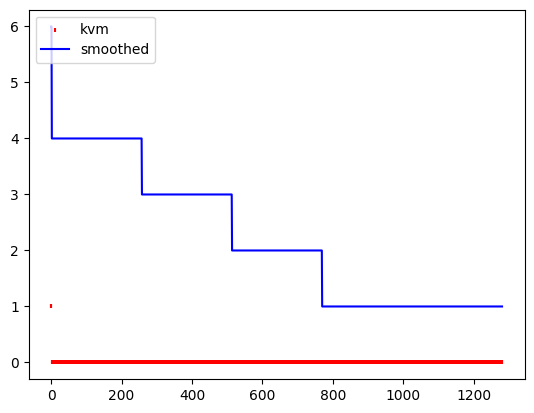

In [132]:
def smooth_sequence(seq, max_dist=6):
    n = len(seq)
    # Initialize a list to store distances to the nearest '1'
    distances = [float('inf')] * n

    # First pass: find distances from left to right
    for i in range(n):
        if seq[i] == 1:
            distances[i] = 0
        elif i > 0 and distances[i-1] != float('inf'):
            distances[i] = distances[i-1] + 1

    # Second pass: find distances from right to left
    for i in range(n-2, -1, -1):
        if distances[i+1] != float('inf'):
            distances[i] = min(distances[i], distances[i+1] + 1)

    # Determine the maximum distance to scale values
    max_distance = max(distances)

    # Assign values based on proximity to '1'
    transformed = []
    for dist in distances:
        if dist == 0:
            transformed.append(max_dist)  # '1' corresponds to 10
        else:
            # Scale each zero to be between 0 and 9 based on its distance
            scaled_value = int((1 - (dist / max_distance)) ** 1 * (max_dist - 1))
            transformed.append(max(1, scaled_value))

    return transformed

n = len(df)
plt.scatter(np.arange(n), df['key_moment'], s=10, c='r', marker='|', label='kvm')
plt.plot(np.arange(n), smooth_sequence(df['key_moment']), c='b', label='smoothed')
plt.legend(loc='upper left')
plt.show()

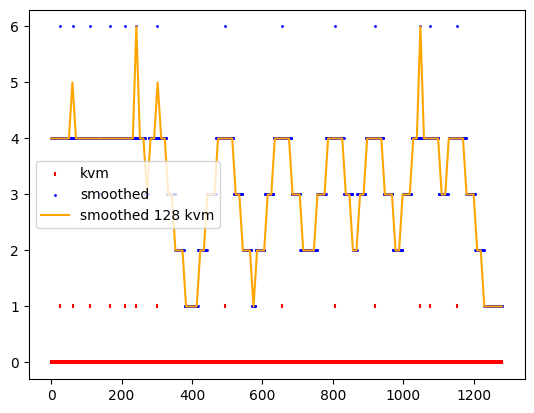

In [5]:
import numpy as np
from scipy.interpolate import interp1d

def resize_sequence(seq, target_length=128):
    # Convert sequence to numpy array for easier handling
    original_length = len(seq)
    original_indices = np.linspace(0, original_length - 1, num=original_length)
    target_indices = np.linspace(0, original_length - 1, num=target_length)
    
    # Create interpolation function
    interpolation_function = interp1d(original_indices, seq, kind='linear')
    
    # Generate new sequence of the target length
    new_sequence = interpolation_function(target_indices)
    # Round values to maintain integer type consistency
    new_sequence = np.round(new_sequence).astype(int)
    
    return new_sequence.tolist()

# resize_sequence(smooth_sequence(df['key_moment'], max_dist=5))

n = len(df)
kvm = df['key_moment']
smoothed_kvm = smooth_sequence(df['key_moment'], max_dist=6)
smoothed_128_kvm = resize_sequence(smoothed_kvm)
plt.scatter(np.arange(n), kvm, s=10, c='r', marker='|', label='kvm')
plt.scatter(np.arange(n), smoothed_kvm, c='b', s=1, label='smoothed')
plt.plot(np.linspace(0, n - 1, 128), smoothed_128_kvm, c='orange', label='smoothed 128 kvm')
plt.legend(loc='center left')
plt.show()

In [9]:
from pprint import pprint


# kvm_seq = json.load(open("./kvm1.json", 'r'))['video_ad81.mp4']
kvm_seq = pd.read_csv('tmp_e2e/csvFile/output.csv', sep=',')['key_moment']

nnotes_seq = resize_sequence(smooth_sequence(df['key_moment']))
nnotes_cfg = [
    {
        'borders': [ind, ind + 1],
        'value': value
    }
    for ind, value in enumerate(nnotes_seq)
]



l, r = 0, 0
nnotes_cfg = []
while r < len(smoothed_128_kvm):  # always *l = *r
    if (r < len(smoothed_128_kvm) - 1) and smoothed_128_kvm[l] == smoothed_128_kvm[r + 1]:
        r += 1
    else:
        nnotes_cfg.append({'borders': [l, r + 1], 'value': smoothed_128_kvm[l]})
        l = r + 1
        r = r + 1
assert nnotes_cfg[-1]['borders'][1] == 128

# json.dump(nnotes_cfg, open(f'tmp_e2e/nnotes_{path_mp4.stem}.json', 'w'))
pprint(nnotes_cfg[:20])

[{'borders': [0, 1], 'value': 4},
 {'borders': [1, 2], 'value': 4},
 {'borders': [2, 3], 'value': 4},
 {'borders': [3, 4], 'value': 4},
 {'borders': [4, 5], 'value': 4},
 {'borders': [5, 6], 'value': 4},
 {'borders': [6, 7], 'value': 5},
 {'borders': [7, 8], 'value': 4},
 {'borders': [8, 9], 'value': 4},
 {'borders': [9, 10], 'value': 4},
 {'borders': [10, 11], 'value': 4},
 {'borders': [11, 12], 'value': 4},
 {'borders': [12, 13], 'value': 4},
 {'borders': [13, 14], 'value': 4},
 {'borders': [14, 15], 'value': 4},
 {'borders': [15, 16], 'value': 4},
 {'borders': [16, 17], 'value': 4},
 {'borders': [17, 18], 'value': 4},
 {'borders': [18, 19], 'value': 4},
 {'borders': [19, 20], 'value': 4}]


## kmv4.csv plot

In [19]:
df = pd.read_csv(
    'generated_4x2x2/video_ad25/kvm4.csv'
)

df.query('key_moment == 1')

,frame_ind,key_moment,fps
0,0,1.0,25.0
138,138,1.0,25.0
237,237,1.0,25.0
364,364,1.0,25.0
391,391,1.0,25.0
1157,1157,1.0,25.0


## nnotes4.json plot

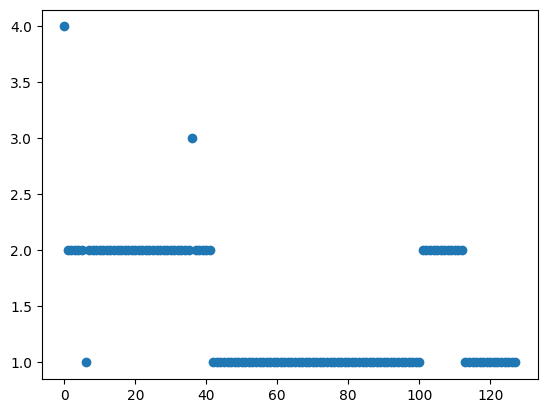

In [11]:
cfg = json.load(open('generated_4x2x2/video_ad25/nnotes4.json', 'r'))

x = np.arange(128)
y = np.arange(128)
for part in cfg:
    y[part['borders'][0]: part['borders'][1]] = part['value']
    
plt.scatter(x, y)

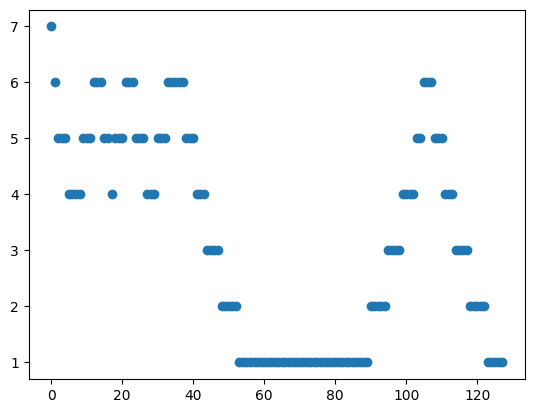

In [20]:
cfg = json.load(open('generated_4x2x2/video_ad25/nnotes4.json', 'r'))

x = np.arange(128)
y = np.arange(128)
for part in cfg:
    y[part['borders'][0]: part['borders'][1]] = part['value']
    
plt.scatter(x, y)

# 4. music-transformer with nnotes

In [15]:
%cd /storage/arkady/Glinka/music-transformer/video_conditioning
df = pd.read_csv('tmp_e2e/csvFile/output.csv', sep=',')
video_length_s = len(df) / df.iloc[-1, -1]
video_length_s

/storage/arkady/Glinka/music-transformer/video_conditioning


55.32

In [26]:
# v0
import sys
# sys.path.append('/storage/arkady/Glinka/music-transformer/video_conditioning/code3')
# sys.path.append('/storage/arkady/Glinka/music-transformer/video_conditioning')
# sys.path.append('/storage/arkady/Glinka/music-transformer')

!pwd
%cd /storage/arkady/Glinka/music-transformer/video_conditioning/code3/generation
# %cd /storage/arkady/Glinka/music-transformer/video_conditioning # зачем?

'''
Arguments:
    model_weights.pickle path
    time_ms - length of generated music  *10ms
    sentiment - not used
    genre - from GENRES_LIST = ('pop', 'jazz', 'rock', 'blues', ...)
    output_dir
    output_name
    nnotes_path.json

Returns:
    saves config - modified from generate_sample_parameters.json
    runs code3/generate_sample.py

    creates output_dir/output_name.wav
    creates output_dir/output_name.mp3
'''


!CUDA_VISIBLE_DEVICES=5 \
/storage/arkady/miniconda3/envs/transformer_production/bin/python \
/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_e2e.py \
'/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' \
{int(video_length_s * 100)} 0 2 'tmp_e2e' 'e2e_81' '/storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/nnotes_video_ad81.json'

/storage/arkady/Glinka/music-transformer/video_conditioning/code3
/storage/arkady/Glinka/music-transformer/video_conditioning/code3/generation
======= /storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e e2e_81
[{'borders': [0, 1], 'value': 1},
 {'borders': [1, 2], 'value': 2},
 {'borders': [2, 3], 'value': 2},
 {'borders': [3, 4], 'value': 2}]
==== then
=====generate_samples====== /storage/arkady/Glinka/music-transformer/video_conditioning/code3/generation
{'force_cpu': False,
 'generation_params': {'additional_features_params': {'author': '[UNK]',
                                                      'genre': 'rock',
                                                      'nnotes': {'enable': True,
                                                                 'preset': [{'borders': [0,
                                                                                         1],
                                                                             'value': 1},
  

In [ ]:
!CUDA_VISIBLE_DEVICES=5 \
/storage/arkady/miniconda3/envs/transformer_production/bin/python3 \
/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_e2e.py \
'/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' \
1190 0 2 'tmp_e2e' 'e2e_81' '/storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/nnotes_video_ad81.json'

In [27]:
# v1
import subprocess

proc = subprocess.run(';'.join([
    'cd /storage/arkady/Glinka/music-transformer/video_conditioning/code3',
    'pwd',
    f"""
CUDA_VISIBLE_DEVICES=0 \
/storage/arkady/miniconda3/envs/transformer_production/bin/python \
/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_e2e.py \
'/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' \
{int(video_length_s * 100)} 0 2 'tmp_e2e' 'e2e_{path_mp4.stem}' \
'/storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/nnotes_{path_mp4.stem}.json'
    """
]), shell=True, capture_output=True, text=True)

print(proc.stdout)
print('##################')
print(proc.stderr)

NameError: name 'video_length_s' is not defined

In [40]:
# v2
import subprocess

def stream_subprocess_output(command):
    process = subprocess.Popen(
        command,
        shell=True,
        executable="/bin/bash",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    while True:
        output = process.stdout.readline()
        if output == '' and process.poll() is not None:
            break
        if output:
            print(output.strip())

    err = process.stderr.read()
    if err:
        print("Error:", err.strip())

command = ';'.join([
    'cd /storage/arkady/Glinka/music-transformer/video_conditioning/code3',
    'pwd',
    f"""
CUDA_VISIBLE_DEVICES=0 \
/storage/arkady/miniconda3/envs/transformer_production/bin/python \
/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_e2e.py \
'/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' \
{int(video_length_s * 100)} 0 2 'tmp_e2e' 'e2e_{path_mp4.stem}' \
'/storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/nnotes_{path_mp4.stem}.json'
    """
])

# stream_subprocess_output("for i in {1..5}; do echo $i; sleep 1; done")
stream_subprocess_output(command)

/storage/arkady/Glinka/music-transformer/video_conditioning/code3
==== then
=====generate_samples====== /storage/arkady/Glinka/music-transformer/video_conditioning/code3
------ /storage/arkady/Glinka/music-transformer/video_conditioning/code3
FluidSynth runtime version 2.1.7
Copyright (C) 2000-2021 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file '/storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/e2e_video_ad25/e2e_video_ad25.mp3'..
======= /storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e e2e_video_ad25
[{'borders': [0, 1], 'value': 3},
{'borders': [1, 2], 'value': 4},
{'borders': [2, 3], 'value': 4},
{'borders': [3, 4], 'value': 4}]
Error: timing_segments:   0%|          | 0/127 [00:00<?, ?it/s]
timing_segments: 390it [00:04, 86.05it/s]               
timing_segments: 399it [00:11, 27.05it/s]
timing_segments: 403it [00:14, 19.76it/s]
timing_segments: 

In [ ]:
# v3
import subprocess

def stream_subprocess_output(command):
    # Start the subprocess using bash explicitly
    process = subprocess.Popen(
        command,
        shell=True,
        executable="/bin/bash",  # Specify the Bash executable
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    # Monitor both stdout and stderr
    while True:
        # Poll process for new output: both stdout and stderr
        output = process.stdout.readline()
        error_output = process.stderr.readline()

        # Check if subprocess has terminated and stdout/stderr are empty
        if process.poll() is not None and output == '' and error_output == '':
            break

        # Print any outputs collected to stdout
        if output:
            print(output.strip())

        # Print any errors collected to stderr, where tqdm typically writes
        if error_output:
            print(error_output.strip(), end='')  # Use end='' for tqdm to properly update the line

    # Ensure all output is flushed after subprocess termination
    stdout, stderr = process.communicate()
    if stdout:
        print(stdout.strip())
    if stderr:
        print(stderr.strip())

command = ';'.join([
    'cd /storage/arkady/Glinka/music-transformer/video_conditioning/code3',
    'pwd',
    f"""
CUDA_VISIBLE_DEVICES=0 \
/storage/arkady/miniconda3/envs/transformer_production/bin/python \
/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_e2e.py \
'/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' \
{int(video_length_s * 100)} 0 2 'tmp_e2e' 'e2e_{path_mp4.stem}' \
'/storage/arkady/Glinka/music-transformer/video_conditioning/tmp_e2e/nnotes_{path_mp4.stem}.json'
    """
])

# stream_subprocess_output("for i in {1..5}; do echo $i; sleep 1; done")
stream_subprocess_output(command)

/storage/arkady/Glinka/music-transformer/video_conditioning/code3
==== then
=====generate_samples====== /storage/arkady/Glinka/music-transformer/video_conditioning/code3
------ /storage/arkady/Glinka/music-transformer/video_conditioning/code3


# 5. combine mp4 and mp3, video and audio

In [4]:
!pwd
path_mp4 = '/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad27.mp4'
video_path = str(path_mp4)
audio_path = 'tmp_e2e_1/video_ad27_gen/video_ad27_gen.mp3'
output_path = f'tmp_e2e_1/GLUED.mp4'

assert os.path.exists(video_path)
assert os.path.exists(audio_path)

/storage/arkady/Glinka/music-transformer/video_conditioning


In [6]:
from moviepy.editor import VideoFileClip, AudioFileClip, CompositeVideoClip, concatenate_audioclips

def merge_video_audio(video_path, audio_path, output_path):
    # Load the video file
    video_clip = VideoFileClip(video_path)
    
    # Load the audio file
    audio_clip = AudioFileClip(audio_path)
    
    # The duration of the video
    video_duration = video_clip.duration

    # Check if the audio clip is shorter than the video clip
    if audio_clip.duration < video_duration:
        # Calculate the number of times the audio needs to be repeated
        repeat_count = int(video_duration // audio_clip.duration) + 1
        # Create a new audio clip by concatenating the audio clip with itself
        audio_clip = concatenate_audioclips([audio_clip] * repeat_count)
    
    # Set the duration of the audio clip to match the video clip's duration
    audio_clip = audio_clip.set_duration(video_duration)
    
    # Set the audio of the video clip to the audio clip
    video_clip = video_clip.set_audio(audio_clip)
    
    # Write the result to a file
    video_clip.write_videofile(output_path, codec='libx264', audio_codec='libmp3lame', fps=video_clip.fps)

# # Example usage

merge_video_audio(video_path, audio_path, output_path)

Moviepy - Building video tmp_e2e_1/GLUED.mp4.
FPS3= 23.976023976023978
MoviePy - Writing audio in GLUEDTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
FPS= 23.976023976023978
Moviepy - Writing video tmp_e2e_1/GLUED.mp4

FPS2= 23.976023976023978
FPS1= 23.976023976023978
a


Moviepy - Done !
Moviepy - video ready tmp_e2e_1/GLUED.mp4


# 6 script execution

In [145]:
!CUDA_VISIBLE_DEVICES=0 \
/storage/arkady/miniconda3/envs/VideoMusic/bin/python3 \
/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_video.py \
'/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' \
7777 0 2 'generated_4x2x2' \
'video_ad14_v2_g2' \
'/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4' \
0

obj='generate_music_for_video'
obj='#1'
VideoManager is deprecated and will be removed.
obj='#3'
obj='#3.5'
['/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_video.py', '/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle', '7777', '0', '11', 'generated_4x2x2', 'video_ad14_v2', '/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4', '0']
obj='create_config'
obj='#4'
command='cd code3;\n    /storage/arkady/miniconda3/envs/transformer_production/bin/python -m     generation.generate_sample     /storage/arkady/Glinka/music-transformer/video_conditioning/generated_4x2x2/video_ad14/generate_sample_video_ad14_parameters.json     '
ggs cd code3;
    /storage/arkady/miniconda3/envs/transformer_production/bin/python -m     generation.generate_sample     /storage/arkady/Glinka/music-transformer/video_conditioning/generated_4x2x2/video_ad14/generate_sample_video_ad14_parameters.json     
ggs pr.stdout


In [62]:
!CUDA_VISIBLE_DEVICES=5 /storage/arkady/miniconda3/envs/VideoMusic/bin/python3 /storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_video.py '/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' 77777 0 11 'best4videos' 'video_ad5_rs0' '/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad5.mp4' 0

obj='generate_music_for_video'
obj='#1'
MoviePy - Writing audio in /storage/arkady/Glinka/music-transformer/video_conditioning/best4videos/video_ad5.mp3
MoviePy - Done.                                                                 
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/music-transformer/video_conditioning/best4videos/video_ad5.mp3')
loading model... done
loading wave source... done
stft of wave source... done
100%|█████████████████████████████████████████████| 3/3 [02:39<00:00, 53.23s/it]
validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/music-transformer/video_conditioning/best4videos/video_ad5_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/music-transformer/video_conditioning/best4videos/video_ad5_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...
2024-05-10 19:34:16.733946: F tensor

генерим музыку с nnotes для Жени Григоровича

In [ ]:
!CUDA_VISIBLE_DEVICES=5 \
/storage/arkady/miniconda3/envs/VideoMusic/bin/python3 \
/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_video.py \
'/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' \
7777 0 11 'generated_4x2x2' \
'video_ad14_v2_rs0' \
'/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad14.mp4' \
0

# 7 multiple scripts execution

In [29]:
# selected_videos = [14, 25, 5, ]  # best
selected_videos = [17, 32, 38]  # others
gpus = ['0', '1', '5']
genre = 11

for video_suf, gpu in zip(selected_videos, gpus):
    script = f'scripts/gen_script_video_gpu{gpu}_ad{video_suf}_g{genre}_4x2x2.sh'
    with open(script, '+w') as f:
        for rs in range(1):
            f.write(f'''
CUDA_VISIBLE_DEVICES={gpu} \\
/storage/arkady/miniconda3/envs/VideoMusic/bin/python3 \\
/storage/arkady/Glinka/music-transformer/video_conditioning/gen_script_video.py \\
'/storage/arkady/Glinka/music-transformer/video_conditioning/model/epoch_0037.pickle' \\
77777 0 {genre} 'generated_4x2x2' \\
'video_ad{video_suf}_v2_rs{rs}_g{genre}' \\
'/storage/arkady/Glinka/music-transformer/video_conditioning/content/video_data/video_ad{video_suf}.mp4' \\
{rs} {gpu}

''')
    print(script)
    !chmod +x {script}

scripts/gen_script_video_gpu0_ad17_g11_4x2x2.sh
scripts/gen_script_video_gpu1_ad32_g11_4x2x2.sh
scripts/gen_script_video_gpu5_ad38_g11_4x2x2.sh


# download mp4

In [94]:
# SAVING TO ARCHIVE
import os

files = []
for rs in range(11):
    for ind in [25, 5, 14, 17, 27]:
        path = f"best4videos/video_ad{ind}_rs{rs}/video_ad{ind}_rs{rs}.mp4"
        if not os.path.exists(path):
            continue
        # print(path)
        files.append(path)

command = f'tar -czvf e2e_{len(files)}_examples.tar.gz ' + ' '.join(files)
print(command)

# !{command}

tar -czvf e2e_51_examples.tar.gz best4videos/video_ad25_rs0/video_ad25_rs0.mp4 best4videos/video_ad5_rs0/video_ad5_rs0.mp4 best4videos/video_ad14_rs0/video_ad14_rs0.mp4 best4videos/video_ad17_rs0/video_ad17_rs0.mp4 best4videos/video_ad27_rs0/video_ad27_rs0.mp4 best4videos/video_ad25_rs1/video_ad25_rs1.mp4 best4videos/video_ad5_rs1/video_ad5_rs1.mp4 best4videos/video_ad14_rs1/video_ad14_rs1.mp4 best4videos/video_ad17_rs1/video_ad17_rs1.mp4 best4videos/video_ad27_rs1/video_ad27_rs1.mp4 best4videos/video_ad25_rs2/video_ad25_rs2.mp4 best4videos/video_ad5_rs2/video_ad5_rs2.mp4 best4videos/video_ad14_rs2/video_ad14_rs2.mp4 best4videos/video_ad17_rs2/video_ad17_rs2.mp4 best4videos/video_ad27_rs2/video_ad27_rs2.mp4 best4videos/video_ad25_rs3/video_ad25_rs3.mp4 best4videos/video_ad5_rs3/video_ad5_rs3.mp4 best4videos/video_ad17_rs3/video_ad17_rs3.mp4 best4videos/video_ad27_rs3/video_ad27_rs3.mp4 best4videos/video_ad25_rs4/video_ad25_rs4.mp4 best4videos/video_ad5_rs4/video_ad5_rs4.mp4 best4videos

In [103]:
from video_utils.kvm import draw_kvm_on_video

draw_kvm_on_video(
    'tmp_e2e/video_ad27_red/video_ad27_red.mp4',
    'tmp_e2e/video_ad27_red/video_ad27_kvm.mp4',
    'tmp_e2e/video_ad27/kvm2.csv',
)

Moviepy - Building video tmp_e2e/video_ad27_red/video_ad27_kvm.mp4.
MoviePy - Writing audio in video_ad27_kvmTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video tmp_e2e/video_ad27_red/video_ad27_kvm.mp4

FPS2= 23.0
FPS1= 23.0


Moviepy - Done !
Moviepy - video ready tmp_e2e/video_ad27_red/video_ad27_kvm.mp4
Video processing complete and saved to: tmp_e2e/video_ad27_red/video_ad27_kvm.mp4


In [107]:
import os
import shutil
import tempfile
from video_utils.kvm import draw_kvm_on_video

# Create a temporary directory
tmp_dir = tempfile.mkdtemp()

# Find and collect file paths
files = []
for rs in range(11):
    for ind in [25, 5, 14, 17, 27]:
        print(rs, ind)
        path = f"best4videos/video_ad{ind}_rs{rs}/video_ad{ind}_rs{rs}.mp4"
        if os.path.exists(path):
            new_path = path.replace('.mp4', '_kvm.mp4')
            draw_kvm_on_video(
                input_video_path=path,
                output_video_path=new_path,
                path_kvm=f"best4videos/video_ad{ind}/kvm2.csv"
            )
            # Copy file to the temporary directory
            shutil.copy(new_path, os.path.join(tmp_dir, os.path.basename(path)))
            # Collect the path of the copied file
            files.append(os.path.join(tmp_dir, os.path.basename(new_path)))

# Check if files were copied and proceed to archive
if files:
    # Generate the tar.gz archive of the temporary directory
    archive_name = f"e2e_{len(files)}_examples.tar.gz"
    command = f"tar -czvf {archive_name} -C {tmp_dir} ."
    os.system(command)  # Execute the command to create the archive
    print(f"Archive created: {archive_name}")
else:
    print("No files to archive.")

# Optional: Clean up by removing the temporary directory
shutil.rmtree(tmp_dir)

0 25


t:   0%|          | 2/1384 [01:17<14:56:37, 38.93s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs0/video_ad25_rs0_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs0_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [01:20<15:29:46, 40.37s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs0/video_ad25_rs0_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [02:07<24:29:43, 63.81s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs0/video_ad25_rs0_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs0/video_ad25_rs0_kvm.mp4
0 5


t:   0%|          | 2/1384 [02:31<29:01:06, 75.59s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs0/video_ad5_rs0_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs0_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [02:32<29:18:49, 76.36s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs0/video_ad5_rs0_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [03:01<34:53:26, 90.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs0/video_ad5_rs0_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs0/video_ad5_rs0_kvm.mp4
0 14


t:   0%|          | 2/1384 [03:08<36:08:36, 94.15s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs0/video_ad14_rs0_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs0_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [03:10<36:32:34, 95.19s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs0/video_ad14_rs0_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [03:19<38:18:17, 99.78s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs0/video_ad14_rs0_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs0/video_ad14_rs0_kvm.mp4
0 17


t:   0%|          | 2/1384 [03:32<40:45:32, 106.17s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs0/video_ad17_rs0_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs0_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [03:35<41:22:44, 107.79s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs0/video_ad17_rs0_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [03:56<45:27:13, 118.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs0/video_ad17_rs0_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs0/video_ad17_rs0_kvm.mp4
0 27


t:   0%|          | 2/1384 [04:01<46:22:41, 120.81s/it, now=None]

Moviepy - Building video best4videos/video_ad27_rs0/video_ad27_rs0_kvm.mp4.
MoviePy - Writing audio in video_ad27_rs0_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [04:02<46:27:56, 121.04s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad27_rs0/video_ad27_rs0_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [04:07<47:31:58, 123.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad27_rs0/video_ad27_rs0_kvm.mp4
Video processing complete and saved to: best4videos/video_ad27_rs0/video_ad27_rs0_kvm.mp4
1 25


t:   0%|          | 2/1384 [04:51<55:59:58, 145.87s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs1/video_ad25_rs1_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs1_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [04:54<56:31:04, 147.22s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs1/video_ad25_rs1_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [05:39<65:13:48, 169.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs1/video_ad25_rs1_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs1/video_ad25_rs1_kvm.mp4
1 5


t:   0%|          | 2/1384 [06:08<70:48:31, 184.45s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs1/video_ad5_rs1_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs1_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [06:10<71:09:46, 185.37s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs1/video_ad5_rs1_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [06:41<77:05:49, 200.83s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs1/video_ad5_rs1_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs1/video_ad5_rs1_kvm.mp4
1 14


t:   0%|          | 2/1384 [06:49<78:30:26, 204.51s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs1/video_ad14_rs1_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs1_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [06:51<78:59:06, 205.75s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs1/video_ad14_rs1_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [07:00<80:40:52, 210.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs1/video_ad14_rs1_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs1/video_ad14_rs1_kvm.mp4
1 17


t:   0%|          | 2/1384 [07:13<83:10:42, 216.67s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs1/video_ad17_rs1_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs1_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [07:16<83:49:15, 218.35s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs1/video_ad17_rs1_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [07:37<87:50:03, 228.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs1/video_ad17_rs1_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs1/video_ad17_rs1_kvm.mp4
1 27


t:   0%|          | 2/1384 [07:42<88:50:40, 231.43s/it, now=None]

Moviepy - Building video best4videos/video_ad27_rs1/video_ad27_rs1_kvm.mp4.
MoviePy - Writing audio in video_ad27_rs1_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [07:43<88:55:16, 231.63s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad27_rs1/video_ad27_rs1_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [07:48<89:58:41, 234.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad27_rs1/video_ad27_rs1_kvm.mp4
Video processing complete and saved to: best4videos/video_ad27_rs1/video_ad27_rs1_kvm.mp4
2 25


t:   0%|          | 2/1384 [08:31<98:11:33, 255.78s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs2/video_ad25_rs2_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs2_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [08:34<98:43:03, 257.15s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs2/video_ad25_rs2_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [09:18<107:15:53, 279.42s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs2/video_ad25_rs2_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs2/video_ad25_rs2_kvm.mp4
2 5


t:   0%|          | 2/1384 [09:45<112:19:16, 292.59s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs2/video_ad5_rs2_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs2_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [09:46<112:37:01, 293.36s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs2/video_ad5_rs2_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [10:15<118:13:32, 307.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs2/video_ad5_rs2_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs2/video_ad5_rs2_kvm.mp4
2 14


t:   0%|          | 2/1384 [10:23<119:43:07, 311.86s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs2/video_ad14_rs2_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs2_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [10:26<120:16:28, 313.31s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs2/video_ad14_rs2_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [10:35<122:00:03, 317.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs2/video_ad14_rs2_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs2/video_ad14_rs2_kvm.mp4
2 17


t:   0%|          | 2/1384 [10:48<124:33:10, 324.45s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs2/video_ad17_rs2_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs2_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [10:53<125:29:54, 326.91s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs2/video_ad17_rs2_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [11:15<129:43:29, 337.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs2/video_ad17_rs2_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs2/video_ad17_rs2_kvm.mp4
2 27


t:   0%|          | 2/1384 [11:21<130:43:00, 340.51s/it, now=None]

Moviepy - Building video best4videos/video_ad27_rs2/video_ad27_rs2_kvm.mp4.
MoviePy - Writing audio in video_ad27_rs2_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [11:21<130:48:44, 340.76s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad27_rs2/video_ad27_rs2_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [11:27<131:58:41, 343.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad27_rs2/video_ad27_rs2_kvm.mp4
Video processing complete and saved to: best4videos/video_ad27_rs2/video_ad27_rs2_kvm.mp4
3 25


t:   0%|          | 2/1384 [12:11<140:25:27, 365.79s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs3/video_ad25_rs3_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs3_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [12:14<140:58:58, 367.25s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs3/video_ad25_rs3_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [12:58<149:26:04, 389.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs3/video_ad25_rs3_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs3/video_ad25_rs3_kvm.mp4
3 5


t:   0%|          | 2/1384 [13:24<154:24:14, 402.21s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs3/video_ad5_rs3_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs3_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [13:25<154:41:32, 402.96s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs3/video_ad5_rs3_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [13:54<160:05:00, 417.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs3/video_ad5_rs3_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs3/video_ad5_rs3_kvm.mp4
3 14
3 17


t:   0%|          | 2/1384 [14:07<162:41:20, 423.79s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs3/video_ad17_rs3_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs3_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [14:10<163:18:54, 425.42s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs3/video_ad17_rs3_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [14:32<167:27:17, 436.21s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs3/video_ad17_rs3_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs3/video_ad17_rs3_kvm.mp4
3 27


t:   0%|          | 2/1384 [14:36<168:16:19, 438.34s/it, now=None]

Moviepy - Building video best4videos/video_ad27_rs3/video_ad27_rs3_kvm.mp4.
MoviePy - Writing audio in video_ad27_rs3_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [14:37<168:20:46, 438.53s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad27_rs3/video_ad27_rs3_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [14:42<169:18:35, 441.04s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad27_rs3/video_ad27_rs3_kvm.mp4
Video processing complete and saved to: best4videos/video_ad27_rs3/video_ad27_rs3_kvm.mp4
4 25


t:   0%|          | 2/1384 [15:25<177:33:18, 462.52s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs4/video_ad25_rs4_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs4_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [15:27<178:03:11, 463.81s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs4/video_ad25_rs4_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [16:08<185:59:36, 484.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs4/video_ad25_rs4_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs4/video_ad25_rs4_kvm.mp4
4 5


t:   0%|          | 2/1384 [16:34<190:52:48, 497.23s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs4/video_ad5_rs4_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs4_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [16:36<191:11:15, 498.03s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs4/video_ad5_rs4_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [17:05<196:48:05, 512.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs4/video_ad5_rs4_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs4/video_ad5_rs4_kvm.mp4
4 14


t:   0%|          | 2/1384 [17:13<198:18:37, 516.58s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs4/video_ad14_rs4_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs4_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [17:15<198:44:07, 517.69s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs4/video_ad14_rs4_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [17:24<200:26:22, 522.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs4/video_ad14_rs4_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs4/video_ad14_rs4_kvm.mp4
4 17


t:   0%|          | 2/1384 [17:37<202:57:51, 528.71s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs4/video_ad17_rs4_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs4_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [17:40<203:37:03, 530.41s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs4/video_ad17_rs4_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [18:01<207:37:26, 540.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs4/video_ad17_rs4_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs4/video_ad17_rs4_kvm.mp4
4 27


t:   0%|          | 2/1384 [18:07<208:41:05, 543.61s/it, now=None]

Moviepy - Building video best4videos/video_ad27_rs4/video_ad27_rs4_kvm.mp4.
MoviePy - Writing audio in video_ad27_rs4_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [18:07<208:46:22, 543.84s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad27_rs4/video_ad27_rs4_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [18:13<209:53:54, 546.77s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad27_rs4/video_ad27_rs4_kvm.mp4
Video processing complete and saved to: best4videos/video_ad27_rs4/video_ad27_rs4_kvm.mp4
5 25


t:   0%|          | 2/1384 [18:55<217:51:40, 567.51s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs5/video_ad25_rs5_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs5_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [18:57<218:20:47, 568.78s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs5/video_ad25_rs5_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [19:39<226:21:48, 589.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs5/video_ad25_rs5_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs5/video_ad25_rs5_kvm.mp4
5 5


t:   0%|          | 2/1384 [20:04<231:15:40, 602.42s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs5/video_ad5_rs5_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs5_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [20:06<231:31:39, 603.11s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs5/video_ad5_rs5_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [20:32<236:38:48, 616.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs5/video_ad5_rs5_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs5/video_ad5_rs5_kvm.mp4
5 14


t:   0%|          | 2/1384 [20:41<238:13:29, 620.56s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs5/video_ad14_rs5_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs5_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [20:43<238:42:13, 621.80s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs5/video_ad14_rs5_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [20:52<240:25:01, 626.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs5/video_ad14_rs5_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs5/video_ad14_rs5_kvm.mp4
5 17


t:   0%|          | 2/1384 [21:06<243:04:28, 633.19s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs5/video_ad17_rs5_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs5_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [21:09<243:42:34, 634.84s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs5/video_ad17_rs5_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [21:30<247:42:04, 645.24s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs5/video_ad17_rs5_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs5/video_ad17_rs5_kvm.mp4
5 27


t:   0%|          | 2/1384 [21:36<248:50:39, 648.22s/it, now=None]

Moviepy - Building video best4videos/video_ad27_rs5/video_ad27_rs5_kvm.mp4.
MoviePy - Writing audio in video_ad27_rs5_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [21:37<248:57:07, 648.50s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad27_rs5/video_ad27_rs5_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [21:43<250:14:44, 651.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad27_rs5/video_ad27_rs5_kvm.mp4
Video processing complete and saved to: best4videos/video_ad27_rs5/video_ad27_rs5_kvm.mp4
6 25


t:   0%|          | 2/1384 [22:30<259:14:49, 675.32s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs6/video_ad25_rs6_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs6_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [22:33<259:45:35, 676.65s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs6/video_ad25_rs6_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [23:14<267:44:23, 697.44s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs6/video_ad25_rs6_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs6/video_ad25_rs6_kvm.mp4
6 5


t:   0%|          | 2/1384 [23:39<272:25:27, 709.64s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs6/video_ad5_rs6_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs6_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [23:40<272:40:09, 710.28s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs6/video_ad5_rs6_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [24:08<278:02:55, 724.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs6/video_ad5_rs6_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs6/video_ad5_rs6_kvm.mp4
6 14


t:   0%|          | 2/1384 [24:16<279:32:41, 728.19s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs6/video_ad14_rs6_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs6_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [24:18<279:59:27, 729.35s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs6/video_ad14_rs6_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [24:27<281:44:51, 733.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs6/video_ad14_rs6_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs6/video_ad14_rs6_kvm.mp4
6 17


t:   0%|          | 2/1384 [24:41<284:23:59, 740.84s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs6/video_ad17_rs6_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs6_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [24:45<285:04:02, 742.58s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs6/video_ad17_rs6_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [25:07<289:19:02, 753.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs6/video_ad17_rs6_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs6/video_ad17_rs6_kvm.mp4
6 27


t:   0%|          | 2/1384 [25:12<290:24:03, 756.47s/it, now=None]

Moviepy - Building video best4videos/video_ad27_rs6/video_ad27_rs6_kvm.mp4.
MoviePy - Writing audio in video_ad27_rs6_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [25:13<290:29:24, 756.70s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad27_rs6/video_ad27_rs6_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [25:20<291:47:49, 760.11s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad27_rs6/video_ad27_rs6_kvm.mp4
Video processing complete and saved to: best4videos/video_ad27_rs6/video_ad27_rs6_kvm.mp4
7 25


t:   0%|          | 2/1384 [26:04<300:23:30, 782.50s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs7/video_ad25_rs7_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs7_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [26:07<300:53:21, 783.79s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs7/video_ad25_rs7_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [26:49<308:58:20, 804.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs7/video_ad25_rs7_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs7/video_ad25_rs7_kvm.mp4
7 5


t:   0%|          | 2/1384 [27:14<313:43:00, 817.21s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs7/video_ad5_rs7_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs7_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [27:15<313:59:06, 817.91s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs7/video_ad5_rs7_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [27:40<318:47:28, 830.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs7/video_ad5_rs7_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs7/video_ad5_rs7_kvm.mp4
7 14


t:   0%|          | 2/1384 [27:48<320:13:42, 834.17s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs7/video_ad14_rs7_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs7_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [27:51<320:49:20, 835.72s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs7/video_ad14_rs7_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [28:00<322:33:26, 840.24s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs7/video_ad14_rs7_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs7/video_ad14_rs7_kvm.mp4
7 17


t:   0%|          | 2/1384 [28:13<325:05:05, 846.82s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs7/video_ad17_rs7_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs7_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [28:19<326:06:58, 849.51s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs7/video_ad17_rs7_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [28:42<330:33:54, 861.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs7/video_ad17_rs7_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs7/video_ad17_rs7_kvm.mp4
7 27


t:   0%|          | 2/1384 [28:48<331:48:15, 864.32s/it, now=None]

Moviepy - Building video best4videos/video_ad27_rs7/video_ad27_rs7_kvm.mp4.
MoviePy - Writing audio in video_ad27_rs7_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [28:49<331:52:52, 864.52s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad27_rs7/video_ad27_rs7_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [28:54<332:54:15, 867.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad27_rs7/video_ad27_rs7_kvm.mp4
Video processing complete and saved to: best4videos/video_ad27_rs7/video_ad27_rs7_kvm.mp4
8 25


t:   0%|          | 2/1384 [29:47<343:06:23, 893.77s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs8/video_ad25_rs8_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs8_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [29:51<343:46:48, 895.52s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs8/video_ad25_rs8_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [30:40<353:15:04, 920.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs8/video_ad25_rs8_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs8/video_ad25_rs8_kvm.mp4
8 5


t:   0%|          | 2/1384 [31:05<358:09:08, 932.96s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs8/video_ad5_rs8_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs8_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [31:06<358:19:05, 933.39s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs8/video_ad5_rs8_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [31:23<361:35:53, 941.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs8/video_ad5_rs8_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs8/video_ad5_rs8_kvm.mp4
8 14


t:   0%|          | 2/1384 [31:28<362:31:25, 944.35s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs8/video_ad14_rs8_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs8_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [31:31<363:01:15, 945.64s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs8/video_ad14_rs8_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [31:41<365:02:29, 950.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs8/video_ad14_rs8_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs8/video_ad14_rs8_kvm.mp4
8 17


t:   0%|          | 2/1384 [31:56<367:50:41, 958.21s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs8/video_ad17_rs8_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs8_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [31:59<368:22:41, 959.60s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs8/video_ad17_rs8_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [32:25<373:24:12, 972.69s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs8/video_ad17_rs8_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs8/video_ad17_rs8_kvm.mp4
8 27
9 25


t:   0%|          | 2/1384 [33:18<383:40:07, 999.43s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs9/video_ad25_rs9_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs9_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [33:22<384:16:23, 1001.00s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs9/video_ad25_rs9_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [34:09<393:21:13, 1024.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs9/video_ad25_rs9_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs9/video_ad25_rs9_kvm.mp4
9 5


t:   0%|          | 2/1384 [34:37<398:41:07, 1038.54s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs9/video_ad5_rs9_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs9_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [34:38<398:59:37, 1039.35s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs9/video_ad5_rs9_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [35:08<404:38:11, 1054.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs9/video_ad5_rs9_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs9/video_ad5_rs9_kvm.mp4
9 14


t:   0%|          | 2/1384 [35:15<406:00:28, 1057.62s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs9/video_ad14_rs9_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs9_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [35:17<406:27:49, 1058.81s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs9/video_ad14_rs9_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [35:26<408:07:15, 1063.12s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs9/video_ad14_rs9_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs9/video_ad14_rs9_kvm.mp4
9 17


t:   0%|          | 2/1384 [35:39<410:35:03, 1069.54s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs9/video_ad17_rs9_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs9_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [35:42<411:09:07, 1071.02s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs9/video_ad17_rs9_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [36:02<415:02:19, 1081.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs9/video_ad17_rs9_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs9/video_ad17_rs9_kvm.mp4
9 27
10 25


t:   0%|          | 2/1384 [36:41<422:28:24, 1100.51s/it, now=None]

Moviepy - Building video best4videos/video_ad25_rs10/video_ad25_rs10_kvm.mp4.
MoviePy - Writing audio in video_ad25_rs10_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [36:43<423:00:07, 1101.89s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad25_rs10/video_ad25_rs10_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [37:26<431:06:46, 1123.01s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad25_rs10/video_ad25_rs10_kvm.mp4
Video processing complete and saved to: best4videos/video_ad25_rs10/video_ad25_rs10_kvm.mp4
10 5


t:   0%|          | 2/1384 [37:53<436:25:44, 1136.86s/it, now=None]

Moviepy - Building video best4videos/video_ad5_rs10/video_ad5_rs10_kvm.mp4.
MoviePy - Writing audio in video_ad5_rs10_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [37:55<436:51:01, 1137.96s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad5_rs10/video_ad5_rs10_kvm.mp4

FPS2= 30.0
FPS1= 30.0


t:   0%|          | 2/1384 [38:24<442:25:49, 1152.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad5_rs10/video_ad5_rs10_kvm.mp4
Video processing complete and saved to: best4videos/video_ad5_rs10/video_ad5_rs10_kvm.mp4
10 14


t:   0%|          | 2/1384 [38:33<444:01:37, 1156.66s/it, now=None]

Moviepy - Building video best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs10_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [38:35<444:31:16, 1157.94s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4

FPS2= 25.0
FPS1= 25.0


t:   0%|          | 2/1384 [38:45<446:19:34, 1162.64s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4
10 17


t:   0%|          | 2/1384 [38:58<448:53:42, 1169.34s/it, now=None]

Moviepy - Building video best4videos/video_ad17_rs10/video_ad17_rs10_kvm.mp4.
MoviePy - Writing audio in video_ad17_rs10_kvmTEMP_MPY_wvf_snd.mp3


t:   0%|          | 2/1384 [39:02<449:33:54, 1171.08s/it, now=None]

MoviePy - Done.
Moviepy - Writing video best4videos/video_ad17_rs10/video_ad17_rs10_kvm.mp4

FPS2= 23.0
FPS1= 23.0


t:   0%|          | 2/1384 [39:20<453:04:22, 1180.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready best4videos/video_ad17_rs10/video_ad17_rs10_kvm.mp4
Video processing complete and saved to: best4videos/video_ad17_rs10/video_ad17_rs10_kvm.mp4
10 27
./
./video_ad14_rs8.mp4
./video_ad25_rs3.mp4
./video_ad14_rs7.mp4
./video_ad17_rs9.mp4
./video_ad5_rs6.mp4
./video_ad27_rs2.mp4
./video_ad27_rs5.mp4
./video_ad5_rs2.mp4
./video_ad5_rs8.mp4
./video_ad17_rs5.mp4
./video_ad5_rs1.mp4
./video_ad5_rs0.mp4
./video_ad27_rs1.mp4
./video_ad17_rs3.mp4
./video_ad17_rs1.mp4
./video_ad14_rs4.mp4
./video_ad14_rs0.mp4
./video_ad14_rs2.mp4
./video_ad17_rs2.mp4
./video_ad17_rs7.mp4
./video_ad17_rs6.mp4
./video_ad17_rs10.mp4
./video_ad27_rs7.mp4
./video_ad25_rs10.mp4
./video_ad25_rs8.mp4
./video_ad27_rs0.mp4
./video_ad25_rs6.mp4
./video_ad5_rs4.mp4
./video_ad5_rs9.mp4
./video_ad27_rs3.mp4
./video_ad25_rs5.mp4
./video_ad25_rs2.mp4
./video_ad17_rs0.mp4
./video_ad25_rs7.mp4
./video_ad5_rs5.mp4
./video_ad5_rs10.mp4
./video_ad27_rs4.mp4
./video_ad5_rs3.mp4
./video_ad25_rs9.

# 8. Red squares in video at kvm

In [75]:
import cv2
from moviepy.editor import VideoFileClip
import numpy as np
from video_utils.kvm import draw_kvm_on_video  # func

def draw_red_square_and_preserve_audio(
        input_video_path, 
        output_video_path, 
        frames_to_mark, 
        diameter=50, 
        color=(0, 0, 255)
        ):
    """
    Draws a red square at the bottom left corner of specified frames in a video and preserves audio.

    Args:
    input_video_path (str): Path to the input video file.
    output_video_path (str): Path where the output video will be saved.
    frames_to_mark (list): List of frame indices where the square should be drawn.
    square_size (int, optional): Size of the square side in pixels. Default is 50.
    color (tuple, optional): Color of the square in BGR format (Blue, Green, Red). Default is red.
    """
    # Create a temporary video path for the mute video
    temp_video_path = 'temp_output.mp4'

    # Open the input video
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise ValueError("Error opening video file")
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    codec = cv2.VideoWriter_fourcc(*'mp4v')  # Define codec for saving video
    
    # Create a VideoWriter object to save the mute video
    out = cv2.VideoWriter(temp_video_path, codec, fps, (width, height))

    # Process the video
    current_frame = 0
    frames_to_mark = np.array(frames_to_mark)
    colored_frames = np.concatenate([frames_to_mark + shift for shift in range(-2, 3)])
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Check if the current frame or its neighbors need the square
        if current_frame in colored_frames:
            # Coordinates for the square (bottom left corner)

            # start_point = (width - square_size, 0)
            # end_point = (width, square_size)
            # # Draw the rectangle on the frame
            # frame = cv2.rectangle(frame, start_point, end_point, color, -1)
            
            # Coordinates and radius for the circle (top right corner)
            center = (width - diameter // 2, diameter // 2)  # Center of the circle
            radius = diameter // 2  # Radius of the circle
            # Create a copy of the frame to overlay the circle
            overlay = frame.copy()
            # Draw a filled circle on the overlay
            cv2.circle(overlay, center, radius, color, -1)
            # Alpha factor for transparency (between 0 and 1, where 1 is completely opaque)
            alpha = 0.7
            # Apply the overlay with transparency
            frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

        # Write the frame to the output video
        out.write(frame)
        current_frame += 1

    # Release everything when job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # Load the original video and temporary mute video
    original_clip = VideoFileClip(input_video_path)
    video_clip = VideoFileClip(temp_video_path)

    # Set the audio of the original video to the video clip
    video_clip = video_clip.set_audio(original_clip.audio)

    # Write the final video with audio
    video_clip.write_videofile(output_video_path, codec='libx264', audio_codec='libmp3lame', fps=video_clip.fps)

    # Cleanup
    video_clip.close()
    original_clip.close()
    print("Video processing complete and saved to:", output_video_path)

df = pd.read_csv('best4videos/video_ad14/kvm2.csv')
kvm = df.query('key_moment == 1')['frame_ind'].values

# Example usage
draw_red_square_and_preserve_audio(
    input_video_path='best4videos/video_ad14_rs10/video_ad14_rs10.mp4', 
    output_video_path='best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4', 
    frames_to_mark=kvm)


Moviepy - Building video best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4.
MoviePy - Writing audio in video_ad14_rs10_kvmTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4

FPS2= 25.0
FPS1= 25.0


Moviepy - Done !
Moviepy - video ready best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4
Video processing complete and saved to: best4videos/video_ad14_rs10/video_ad14_rs10_kvm.mp4


# 9. Metrics

In [5]:
ind = 32
path_mp4_gen = f'generated_4x2x2/video_ad{ind}_v2_rs0_g2/video_ad{ind}_v2_rs0_g2.mp4'
path_midi_gen = f'generated_4x2x2/video_ad{ind}_v2_rs0_g2/video_ad{ind}_v2_rs0_g2.midi'

path_mp4_orig = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
    / 'content' / 'video_data' / f'video_ad{ind}.mp4'
path_midi_orig = f'generated_4x2x2/video_ad{ind}/video_ad{ind}.mid'

df = pd.read_csv(f'generated_4x2x2/video_ad{ind}/kvm4.csv')
kvm4 = df.query('key_moment == 1').index / df.iloc[-1, -1]  # timings in seconds

[os.path.exists(p) for p in [
    path_mp4_gen,
    path_midi_gen,
    path_mp4_orig,
    path_midi_orig,
    ]]

[False, False, True, True]

# Concordance score

**transformer_production** env

для него требуется находить ключевые моменты в музыке


In [3]:
from video_utils.metrics import get_key_midi_moments
from video_utils.metrics import concordance_score

key_midi_moments = get_key_midi_moments(
        path_midi_orig,
        ['density', 'velocity'][0],
        1 * len(kvm4),
    )

ametric = concordance_score(
    video_moments=kvm4, 
    music_moments=key_midi_moments, 
    alpha=1.0, 
    offset=1, 
    eps=0.1, 
    version='SUM', 
    symmetric=False
)

print(ametric)

plt.scatter(kvm4, np.ones_like(kvm4), label='kvm4')
plt.scatter(key_midi_moments, np.zeros_like(key_midi_moments), label='key midi moments')
plt.legend(loc='right')

NameError: name 'path_midi_orig' is not defined

In [47]:
key_midi_moments, kvm4

([4.0, 12.0, 20.0, 28.0, 60.0, 64.0, 68.0, 72.0, 76.0, 80.0, 92.0, 96.0],
 Float64Index([0.0, 1.0, 1.68, 2.44, 3.04, 4.36, 10.64, 17.44, 19.72, 24.2,
               36.76, 44.16],
              dtype='float64'))

## masha notebook

In [11]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]

    return midi.translate.midiFileToStream(mf)

base_midi = open_midi(path_midi_orig, True)
beatS = [n.beatStrength for n in base_midi.flat.notes]
vols = [n.volume.velocity for n in base_midi.flat.notes]
volsR = ["%.2f"%n.volume.getRealized() for n in base_midi.flat.notes]
print([len(x) for x in [beatS, vols, volsR]])

[169, 169, 169]


In [22]:
import pretty_midi

midi_data = pretty_midi.PrettyMIDI(path_midi_orig)
midi_data.instruments[0].notes[:10]


[Note(start=0.093182, end=0.220455, pitch=40, velocity=50),
 Note(start=1.079545, end=1.359091, pitch=35, velocity=60),
 Note(start=1.359091, end=1.486364, pitch=35, velocity=62),
 Note(start=1.486364, end=1.706818, pitch=35, velocity=78),
 Note(start=1.752273, end=1.834091, pitch=38, velocity=56),
 Note(start=1.834091, end=1.961364, pitch=38, velocity=63),
 Note(start=1.986364, end=2.068182, pitch=55, velocity=38),
 Note(start=1.986364, end=2.079545, pitch=43, velocity=98),
 Note(start=2.079545, end=2.218182, pitch=43, velocity=76),
 Note(start=2.218182, end=2.300000, pitch=40, velocity=61)]

## key_midi_moments gpt 4o

In [41]:
from music21 import converter, midi, stream, note, chord

def open_midi(midi_path, remove_drums):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if remove_drums:
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]
    return midi.translate.midiFileToStream(mf)

def get_key_moments(midi_stream, method='velocity', key_moments_count=5):
    """
    Extracts key moments from the MIDI stream based on the specified method ('velocity' or 'density').

    Parameters:
        midi_stream (stream.Score): The MIDI stream to analyze.
        method (str): The method to use for extracting key moments ('velocity' or 'density').
        key_moments_count (int): The number of key moments to extract.

    Returns:
        list: A list of measures identified as key moments.
    """
    measures = midi_stream.parts[0].getElementsByClass(stream.Measure)
    measure_scores = []

    if method == 'velocity':
        for measure in measures:
            if len(measure.flat.notes) > 0:
                measure_velocity = sum(note.volume.velocity for note in measure.flat.notes if note.volume.velocity is not None) / len(measure.flat.notes)
            else:
                measure_velocity = 0
            measure_scores.append((measure, measure_velocity))

    elif method == 'density':
        for measure in measures:
            density = len(measure.flat.notes)
            measure_scores.append((measure, density))

    # Sort measures by score in descending order and select the top key_moments_count
    measure_scores.sort(key=lambda x: x[1], reverse=True)
    key_moments = sorted([ms[0].offset for ms in measure_scores[:key_moments_count]])

    return key_moments

def get_key_midi_moments(
        path_midi,
        method: str = 'velocity',
        key_moments_count: int = 10,
):
    base_midi = open_midi(path_midi, False)

    key_midi_moments = get_key_moments(
        base_midi, 
        method=method, 
        key_moments_count=key_moments_count
    )

    return key_midi_moments

# # Save the key moments to a new MIDI file
key_moments = get_key_midi_moments(
    path_midi_orig,
    'velocity',
    12
)

key_moments

[4.0, 12.0, 20.0, 28.0, 60.0, 64.0, 68.0, 72.0, 76.0, 80.0, 92.0, 96.0]

## sync score (GPT-4o) - херня

In [130]:
import librosa
import numpy as np

def get_onset_frames(path_mp4, sr=22050):
    y, _ = librosa.load(path_mp4, sr=sr)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    return onset_frames, onset_times

ind = 5
path_mp4_gen = f'generated_4x2x2/video_ad{ind}_v2_rs0_g2/video_ad{ind}_v2_rs0_g2.mp4'
path_midi_gen = f'generated_4x2x2/video_ad{ind}_v2_rs0_g2/video_ad{ind}_v2_rs0_g2.midi'

path_mp4_orig = Path('/storage/arkady/Glinka/music-transformer/video_conditioning') \
    / 'content' / 'video_data' / f'video_ad{ind}.mp4'
path_midi_orig = f'generated_4x2x2/video_ad{ind}/video_ad{ind}.mid'

df = pd.read_csv(f'generated_4x2x2/video_ad{ind}/kvm4.csv')
kvm4 = df.query('key_moment == 1').index / df.iloc[-1, -1]  # timings in seconds

[os.path.exists(p) for p in [
    path_mp4_gen,
    path_midi_gen,
    path_mp4_orig,
    path_midi_gen,
    ]]

_, onset_times_gen = get_onset_frames(path_mp4_gen)
_, onset_times_orig = get_onset_frames(path_mp4_orig)

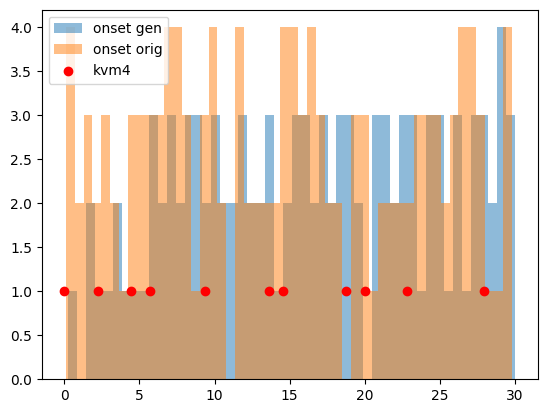

In [131]:
plt.hist(onset_times_gen, label='onset gen', bins=50, density=False, alpha=1/2)
plt.hist(onset_times_orig, label='onset orig', bins=50, density=False, alpha=1/2)
plt.scatter(kvm4, np.ones_like(kvm4), label='kvm4', c='r')

plt.legend()

In [132]:
import librosa
import numpy as np
from pydub import AudioSegment

def extract_key_moments_from_audio(audio_path, sr=22050, frame_length=2048, hop_length=512, top_n=40):
    """
    Extract key moments from an audio file based on loudness.

    Parameters:
        audio_path (str): Path to the audio file.
        sr (int): Sampling rate for loading the audio.
        frame_length (int): Length of the frames for calculating RMS.
        hop_length (int): Number of samples between successive frames.
        top_n (int): Number of top key moments to return.

    Returns:
        key_moments (list): List of times (in seconds) for the top key moments.
    """
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Compute RMS (Root Mean Square) energy for each frame
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    
    # Find the top_n frames with the highest RMS values
    top_indices = np.argsort(rms)[-top_n:]
    
    # Convert frame indices to time in seconds
    key_moments = librosa.frames_to_time(top_indices, sr=sr, hop_length=hop_length)
    
    return sorted(key_moments)

kmm = extract_key_moments_from_audio(path_mp4_orig)

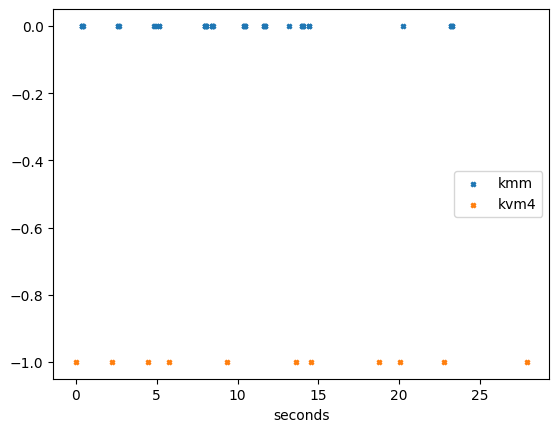

In [133]:
kvms = {
    'kmm': kmm,
    'kvm4': kvm4
}

for i, (name, x) in enumerate(kvms.items()):
    plt.scatter(x, -np.ones_like(x) * i, label=name, s=10, marker='X')
plt.legend(loc='right')
plt.xlabel('seconds')
plt.show()

# Считаем alignment_metric

In [7]:
from video_utils.metrics import get_key_midi_moments
from video_utils.metrics import concordance_score

alignment_metric_params = {
    'alpha': 1.0,
    'offset': 3,
    'eps': 1,
    'version': 'SUM',
    'symmetric': False
}

## nnotes score

In [16]:
from itertools import product


f = open('nnotes_score.txt', 'w')
for ad_id, rs, g in product([5, 14, 25, 32, 38], [0, ], [0, 1, 2, 11]):
    name = f'video_ad{ad_id}_v2_rs{rs}_g{g}'
    root = Path('generated_4x2x2')
    
    path_midi = root / name / (name + '.midi')
    if not path_midi.exists():
        continue

    f.write(str(path_midi) + '\n')
    print(path_midi.stem)

    path_kvm = root / f'video_ad{ad_id}' / 'kvm4.csv'
    df = pd.read_csv(path_kvm)
    kvm4 = df.query('key_moment == 1').index / df.iloc[-1, -1]
    kvm4 = list(kvm4)
    # print(kvm4)

    key_midi_moments = get_key_midi_moments(
        path_midi,
        ['density', 'velocity'][0],
        len(kvm4) * 2,
    )
    key_midi_moments = [float(x) for x in key_midi_moments]
    # print(key_midi_moments)

    score = concordance_score(
        video_moments=kvm4, 
        music_moments=key_midi_moments, 
        **alignment_metric_params
    )

    print(score)
    f.write(str(score) + '\n')

f.close()

video_ad5_v2_rs0_g0


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.06666666666666667
video_ad5_v2_rs0_g2


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.14285714285714285
video_ad5_v2_rs0_g11
0.28
video_ad14_v2_rs0_g0


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.09375
video_ad14_v2_rs0_g1
0.14285714285714285
video_ad14_v2_rs0_g2


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.06060606060606061
video_ad14_v2_rs0_g11
0.20689655172413793
video_ad25_v2_rs0_g0


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.16666666666666666
video_ad25_v2_rs0_g2
0.06060606060606061
video_ad25_v2_rs0_g11


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.16666666666666666
video_ad32_v2_rs0_g11


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.0
video_ad38_v2_rs0_g11
0.1875


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


## original mp4 score

In [17]:
f = open('original_score.txt', 'w')
for ad_id in [5, 14, 25, 32, 38]:
    name = f'video_ad{ad_id}'
    root = Path('generated_4x2x2')
    
    path_midi = root / name / (name + '.mid')
    if not path_midi.exists():
        continue
    
    print()
    print(path_midi.stem)
    f.write(str(path_midi) + '\n')

    path_kvm = root / f'video_ad{ad_id}' / 'kvm4.csv'
    df = pd.read_csv(path_kvm)
    kvm4 = df.query('key_moment == 1').index / df.iloc[-1, -1]
    kvm4 = list(kvm4)
    # print(kvm4)

    key_midi_moments = get_key_midi_moments(
        path_midi,
        ['density', 'velocity'][0],
        len(kvm4) * 2,
    )
    key_midi_moments = [float(x) for x in key_midi_moments]
    # print(key_midi_moments)

    score = concordance_score(
        video_moments=kvm4, 
        music_moments=key_midi_moments, 
        **alignment_metric_params
    )

    print(score)
    f.write(str(score) + '\n')

f.close()


video_ad5
0.3888888888888889

video_ad14


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.25

video_ad25
0.2962962962962963

video_ad32


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.18181818181818182

video_ad38
0.26666666666666666


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


## V2M score

VideoMusic env

In [24]:
import re
from video_utils.metrics import get_key_midi_moments
from video_utils.metrics import concordance_score

def extract_ad_number(file_name):
    match = re.search(r'ad(\d+)', file_name)
    if match:
        return int(match.group(1))
    return None
    
root = Path('/storage/arkady/Glinka/Video2Music_/output/')
for file in os.listdir(root):
    if 'mp4' not in file:
        continue
    print(file)
    path_midi = mp4_to_midi(
    	root / file,
    	output_dir=str(root),
    	group_to_folder=False
    )

    # path_midi = root / (Path(file).stem + '_basic_pitch.mid')
    # path_midi = Path('/storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Instruments_basic_pitch.mid')
    print(path_midi)

    ad_id = extract_ad_number(path_midi.stem)

    path_kvm = Path('generated_4x2x2') / f'video_ad{ad_id}' / 'kvm4.csv'
    df = pd.read_csv(path_kvm)
    kvm4 = df.query('key_moment == 1').index / df.iloc[-1, -1]
    kvm4 = list(kvm4)
    # print(kvm4)

    key_midi_moments = get_key_midi_moments(
        path_midi,
        ['density', 'velocity'][0],
        len(kvm4) * 2,
    )
    key_midi_moments = [float(x) for x in key_midi_moments]
    # print(key_midi_moments)

    score = concordance_score(
        video_moments=kvm4, 
        music_moments=key_midi_moments, 
        **alignment_metric_params
    )

    print(score)


video_ad25___C_major___C_Am_F_G.mp4
MoviePy - Writing audio in /storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G.mp3


MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 5/5 [00:47<00:00,  9.53s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G_Instruments.wav...


  Creating midi...
  🚨 /storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G_Instruments_basic_pitch.mid already exists and would be overwritten. Skipping output files for /storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G_Instruments.wav.
/storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G_Instruments_basic_pitch.mid
0.34615384615384615
video_ad5___G_major___C.mp4
MoviePy - Writing audio in /storage

MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad5___G_major___C.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 3/3 [00:27<00:00,  9.30s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad5___G_major___C_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad5___G_major___C_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad5___G_major___C_Instruments.wav...


  Creating midi...
  💅 Saved to /storage/arkady/Glinka/Video2Music_/output/video_ad5___G_major___C_Instruments_basic_pitch.mid

✨ Done ✨

/storage/arkady/Glinka/Video2Music_/output/video_ad5___G_major___C_Instruments_basic_pitch.mid
0.3888888888888889
video_ad14___D_major___D_G_A_D.mp4
MoviePy - Writing audio in /storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D.mp3


MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 5/5 [00:45<00:00,  9.00s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Instruments.wav...


  Creating midi...
  🚨 /storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Instruments_basic_pitch.mid already exists and would be overwritten. Skipping output files for /storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Instruments.wav.
/storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Instruments_basic_pitch.mid
0.2962962962962963
video_ad25___D_major___D_G_A_D.mp4
MoviePy - Writing audio in /storage

MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad25___D_major___D_G_A_D.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 5/5 [00:49<00:00,  9.88s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad25___D_major___D_G_A_D_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad25___D_major___D_G_A_D_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad25___D_major___D_G_A_D_Instruments.wav...


  Creating midi...
  💅 Saved to /storage/arkady/Glinka/Video2Music_/output/video_ad25___D_major___D_G_A_D_Instruments_basic_pitch.mid

✨ Done ✨

/storage/arkady/Glinka/Video2Music_/output/video_ad25___D_major___D_G_A_D_Instruments_basic_pitch.mid
0.34615384615384615
video_ad5___C_major___C_Am_F_G.mp4
MoviePy - Writing audio in /storage/arkady/Glinka/Video2Music_/output/video_ad5___C_major___C_Am_F_G.mp3


MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad5___C_major___C_Am_F_G.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 3/3 [00:29<00:00,  9.99s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad5___C_major___C_Am_F_G_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad5___C_major___C_Am_F_G_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad5___C_major___C_Am_F_G_Instruments.wav...


  Creating midi...
  💅 Saved to /storage/arkady/Glinka/Video2Music_/output/video_ad5___C_major___C_Am_F_G_Instruments_basic_pitch.mid

✨ Done ✨

/storage/arkady/Glinka/Video2Music_/output/video_ad5___C_major___C_Am_F_G_Instruments_basic_pitch.mid
0.3888888888888889
video_ad5___D_major___D_G_A_D.mp4
MoviePy - Writing audio in /storage/arkady/Glinka/Video2Music_/output/video_ad5___D_major___D_G_A_D.mp3


MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad5___D_major___D_G_A_D.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 3/3 [00:31<00:00, 10.39s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad5___D_major___D_G_A_D_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad5___D_major___D_G_A_D_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad5___D_major___D_G_A_D_Instruments.wav...


  Creating midi...
  💅 Saved to /storage/arkady/Glinka/Video2Music_/output/video_ad5___D_major___D_G_A_D_Instruments_basic_pitch.mid

✨ Done ✨

/storage/arkady/Glinka/Video2Music_/output/video_ad5___D_major___D_G_A_D_Instruments_basic_pitch.mid
0.3888888888888889
video_ad14___C_major___C_Am_F_G.mp4
MoviePy - Writing audio in /storage/arkady/Glinka/Video2Music_/output/video_ad14___C_major___C_Am_F_G.mp3


MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad14___C_major___C_Am_F_G.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 5/5 [00:42<00:00,  8.45s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad14___C_major___C_Am_F_G_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad14___C_major___C_Am_F_G_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad14___C_major___C_Am_F_G_Instruments.wav...


  Creating midi...
  💅 Saved to /storage/arkady/Glinka/Video2Music_/output/video_ad14___C_major___C_Am_F_G_Instruments_basic_pitch.mid

✨ Done ✨

/storage/arkady/Glinka/Video2Music_/output/video_ad14___C_major___C_Am_F_G_Instruments_basic_pitch.mid
0.2962962962962963
video_ad14___G_major___C.mp4
MoviePy - Writing audio in /storage/arkady/Glinka/Video2Music_/output/video_ad14___G_major___C.mp3


MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad14___G_major___C.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 5/5 [00:56<00:00, 11.25s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad14___G_major___C_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad14___G_major___C_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad14___G_major___C_Instruments.wav...


  Creating midi...
  💅 Saved to /storage/arkady/Glinka/Video2Music_/output/video_ad14___G_major___C_Instruments_basic_pitch.mid

✨ Done ✨

/storage/arkady/Glinka/Video2Music_/output/video_ad14___G_major___C_Instruments_basic_pitch.mid
0.2962962962962963
video_ad25___G_major___C.mp4
MoviePy - Writing audio in /storage/arkady/Glinka/Video2Music_/output/video_ad25___G_major___C.mp3


MoviePy - Done.
=====Successfully written new mp3 to path_mp3=PosixPath('/storage/arkady/Glinka/Video2Music_/output/video_ad25___G_major___C.mp3')
loading model... done
loading wave source... done
stft of wave source... done


100%|██████████| 5/5 [00:51<00:00, 10.24s/it]


validating output directory... done
inverse stft of instruments... done
inverse stft of vocals... done
=====Instrumentals at: /storage/arkady/Glinka/Video2Music_/output/video_ad25___G_major___C_Instruments.wav
=====Vocals at: /storage/arkady/Glinka/Video2Music_/output/video_ad25___G_major___C_Vocals.wav

✨✨✨✨✨✨✨✨✨
✨ Basic Pitch  ✨
✨✨✨✨✨✨✨✨✨

Importing Tensorflow (this may take a few seconds)...

Predicting MIDI for /storage/arkady/Glinka/Video2Music_/output/video_ad25___G_major___C_Instruments.wav...


  Creating midi...
  💅 Saved to /storage/arkady/Glinka/Video2Music_/output/video_ad25___G_major___C_Instruments_basic_pitch.mid

✨ Done ✨

/storage/arkady/Glinka/Video2Music_/output/video_ad25___G_major___C_Instruments_basic_pitch.mid
0.2962962962962963


In [18]:
import re
from video_utils.metrics import get_key_midi_moments
from video_utils.metrics import concordance_score

def extract_ad_number(file_name):
    match = re.search(r'ad(\d+)', file_name)
    if match:
        return int(match.group(1))
    return None
    
f = open('v2m_score.txt' , 'w')
root = Path('/storage/arkady/Glinka/Video2Music_/output/')
for file in sorted(os.listdir(root)):
    if 'mp4' not in file:
        continue
    print(file)
    f.write(file + '\n')
    # path_midi = mp4_to_midi(
    # 	root / file,
    # 	output_dir=str(root),
    # 	group_to_folder=False
    # )

    # path_midi = Path('/storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Instruments_basic_pitch.mid')
    path_midi = root / (Path(file).stem + '_Instruments_basic_pitch.mid')
    if not path_midi.exists():
        print('#' * 30)
    print(path_midi)

    ad_id = extract_ad_number(path_midi.stem)

    path_kvm = Path('generated_4x2x2') / f'video_ad{ad_id}' / 'kvm4.csv'
    df = pd.read_csv(path_kvm)
    kvm4 = df.query('key_moment == 1').index / df.iloc[-1, -1]
    kvm4 = list(kvm4)
    # print(kvm4)

    key_midi_moments = get_key_midi_moments(
        path_midi,
        ['density', 'velocity'][0],
        len(kvm4) * 2,
    )
    key_midi_moments = [float(x) for x in key_midi_moments]
    # print(key_midi_moments)

    score = concordance_score(
        video_moments=kvm4, 
        music_moments=key_midi_moments, 
        **alignment_metric_params
    )
    f.write(str(score) + '\n')
    print(score)

f.close()


video_ad14___C_major___C_Am_F_G.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad14___C_major___C_Am_F_G_Instruments_basic_pitch.mid
0.2962962962962963
video_ad14___D_major___D_G_A_D.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad14___D_major___D_G_A_D_Instruments_basic_pitch.mid


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.2962962962962963
video_ad14___G_major___C.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad14___G_major___C_Instruments_basic_pitch.mid
0.2962962962962963
video_ad25___C_major___C_Am_F_G.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad25___C_major___C_Am_F_G_Instruments_basic_pitch.mid


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.34615384615384615
video_ad25___D_major___D_G_A_D.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad25___D_major___D_G_A_D_Instruments_basic_pitch.mid


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.34615384615384615
video_ad25___G_major___C.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad25___G_major___C_Instruments_basic_pitch.mid


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


0.2962962962962963
video_ad5___C_major___C_Am_F_G.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad5___C_major___C_Am_F_G_Instruments_basic_pitch.mid
0.3888888888888889
video_ad5___D_major___D_G_A_D.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad5___D_major___D_G_A_D_Instruments_basic_pitch.mid
0.3888888888888889
video_ad5___G_major___C.mp4
/storage/arkady/Glinka/Video2Music_/output/video_ad5___G_major___C_Instruments_basic_pitch.mid
0.3888888888888889


/storage/arkady/miniconda3/envs/VideoMusic/lib/python3.10/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [94]:
key_midi_moments = get_key_midi_moments(
        path_midi_orig,
        ['density', 'velocity'][0],
        len(kvm4) * 1.5,
    )

ametric = concordance_score(
    video_moments=kvm4, 
    music_moments=key_midi_moments, 
    **alignment_metric_params
)

print(ametric)

0.1


# Configs for MT+velocity

In [13]:
from itertools import product

cfg = {}
for ad_id in ([5, 14, 25, 32, 38]):
    name = f'video_ad{ad_id}'
    root = Path('generated_4x2x2')
    
    path_kvm = root / name / 'kvm4.csv'
    if not path_kvm.exists():
        continue

    # print(path_kvm)
    df = pd.read_csv(path_kvm)
    kvm = df.query('key_moment == 1').index / df.iloc[-1, -1]
    cfg[name + '.mp4'] = list(kvm)

from pprint import pprint

pprint(cfg)

json.dump(cfg, open('MT_velocity_arkady.json', 'w'), indent=4)

{'video_ad14.mp4': [0.0,
                    1.0,
                    1.68,
                    2.44,
                    3.04,
                    4.36,
                    10.64,
                    17.44,
                    19.72,
                    24.2,
                    36.76,
                    44.16],
 'video_ad25.mp4': [0.0,
                    5.52,
                    9.48,
                    12.4,
                    14.56,
                    15.64,
                    17.2,
                    25.28,
                    26.24,
                    33.52,
                    39.28,
                    46.28],
 'video_ad32.mp4': [0.0,
                    1.001,
                    2.2939583333333333,
                    29.988291666666665,
                    32.07370833333333,
                    45.79575,
                    46.671625,
                    48.59020833333333,
                    52.59420833333333],
 'video_ad38.mp4': [0.0,
                    2.125,
  